In [14]:
import scipy.io
from scipy.stats import skew, kurtosis
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, time
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
from scipy.optimize import curve_fit


In [16]:


def prepapre_HI(train_time = 25):


    selected_cols =['MarginFactor', 'SKStd', 'SKSkewness', 'SKKurtosis', 'Mean']
    df = pd.read_csv("vibration_features_smooth.csv")[selected_cols]

    train_selected = df.loc[0:train_time,:] #
    test_selected = df.loc[train_time:,:] 

    scaler = StandardScaler()
    pca = PCA(n_components=2, random_state=42)
    # Normalize the values
    train_scaled = scaler.fit_transform(train_selected)
    # Apply PCA to reduce to 2D
    train_pca = pca.fit_transform(train_scaled)
    # Do the same for test data
    test_scaled = scaler.transform(test_selected)
    test_pca = pca.transform(test_scaled)
    # Do the opration on entire dataset
    full_scaled = scaler.transform(df)
    full_pca = pca.transform(full_scaled)


    # Time indices
    t_train = np.arange(train_pca.shape[0])
    t_test = np.arange(train_pca.shape[0], train_pca.shape[0] + test_pca.shape[0])
    t_full = np.arange(train_pca.shape[0] + test_pca.shape[0] - 1)

    return train_pca[:,0],test_pca[:,0],full_pca[:,0],t_train,t_test,t_full

# LSTM Model


Train MSE: 0.0000 || Test MSE: 47.6307
Train MSE: 0.0000 || Test MSE: 28.0617
Train MSE: 0.0000 || Test MSE: 33.1221
Train MSE: 0.0023 || Test MSE: 23.2473
Train MSE: 0.0000 || Test MSE: 34.9065
Train MSE: 0.0000 || Test MSE: 33.1345
Train MSE: 0.0000 || Test MSE: 26.4847
Train MSE: 0.0000 || Test MSE: 12.8103
Train MSE: 0.0000 || Test MSE: 31.8464
Train MSE: 0.0000 || Test MSE: 33.7003
Train MSE: 0.0001 || Test MSE: 35.9647
Train MSE: 0.0000 || Test MSE: 37.3338
Train MSE: 0.0000 || Test MSE: 40.7795
Train MSE: 0.0001 || Test MSE: 42.2496
Train MSE: 0.0000 || Test MSE: 39.7996
Train MSE: 0.0000 || Test MSE: 40.9215
Train MSE: 0.0000 || Test MSE: 41.5553
Train MSE: 0.0001 || Test MSE: 5.0184
Train MSE: 0.0002 || Test MSE: 6.2348
Train MSE: 0.0008 || Test MSE: 6.1000
Train MSE: 0.0000 || Test MSE: 4.7335


C:\Users\engin\AppData\Local\Temp\ipykernel_19196\2049282567.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


Train MSE: 0.0004 || Test MSE: 13.2114
Train MSE: 0.0035 || Test MSE: 14.6272
Train MSE: 0.0014 || Test MSE: 4.7626
Train MSE: 0.0023 || Test MSE: 4.4521
Train MSE: 0.0042 || Test MSE: 5.6849
Train MSE: 0.0049 || Test MSE: 3.1969
Train MSE: 0.0083 || Test MSE: 4.5768
Train MSE: 0.0015 || Test MSE: 10.8518
Train MSE: 0.0090 || Test MSE: 14.7886
Train MSE: 0.0472 || Test MSE: 13.5352
Train MSE: 0.0371 || Test MSE: 13.8093
Train MSE: 0.0139 || Test MSE: 16.7883
Train MSE: 0.0472 || Test MSE: 5.4841
Train MSE: 0.0323 || Test MSE: 1.9121
Train MSE: 0.2276 || Test MSE: 2.8532
Train MSE: 0.0532 || Test MSE: 4.2814
Train MSE: 0.0565 || Test MSE: 6.9536
Train MSE: 0.2086 || Test MSE: 6.3059
Train MSE: 0.2213 || Test MSE: 4.7322


NameError: name 'num_epochs' is not defined

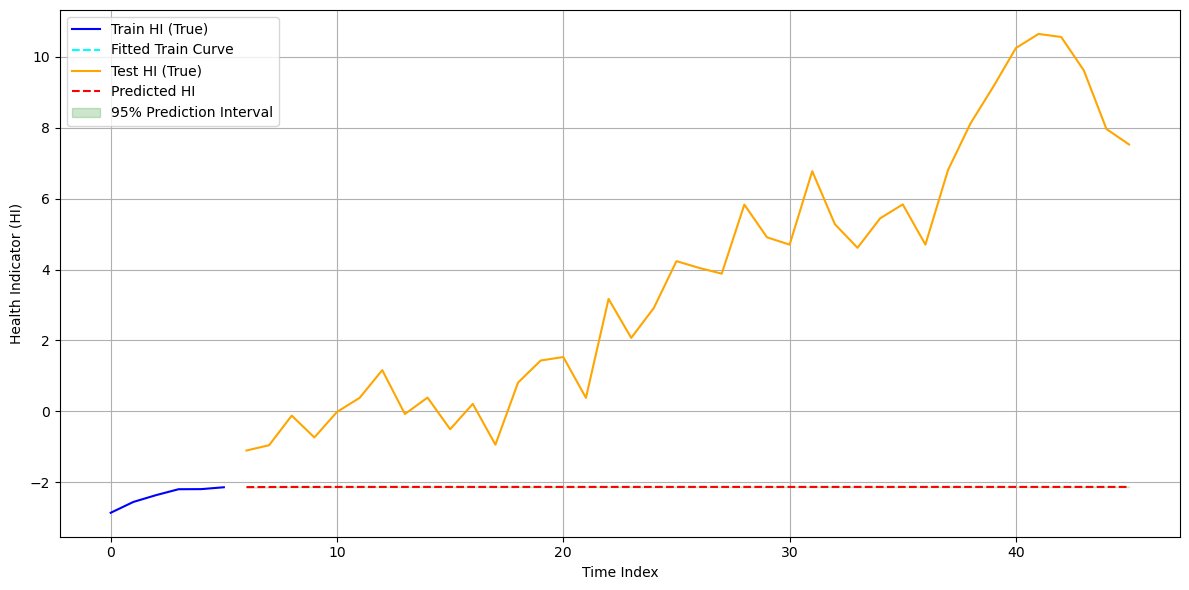

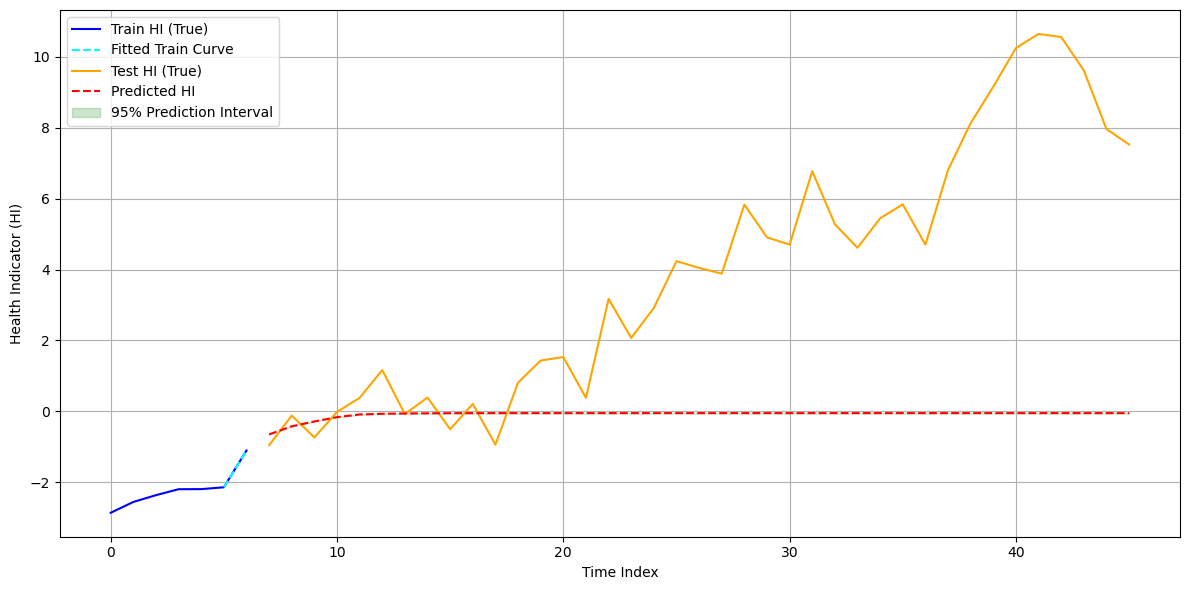

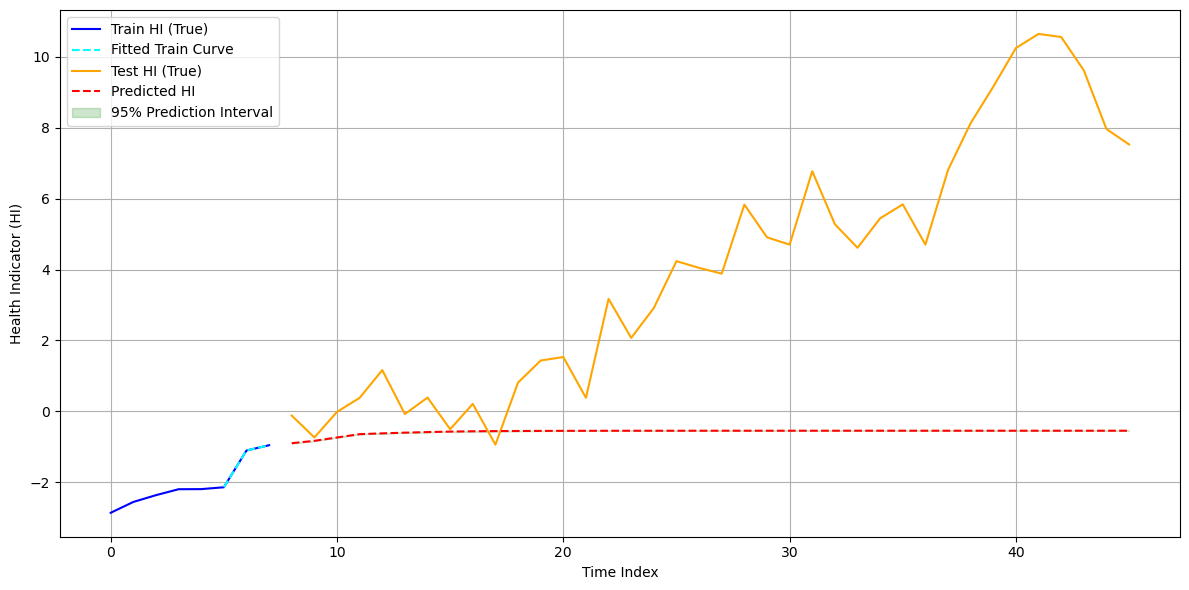

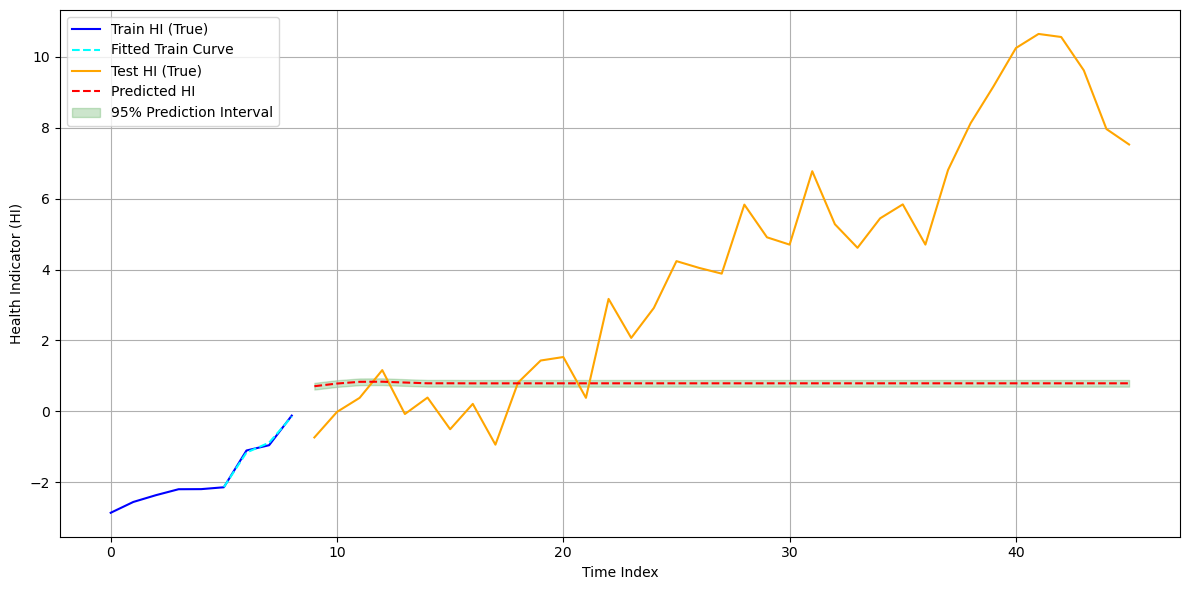

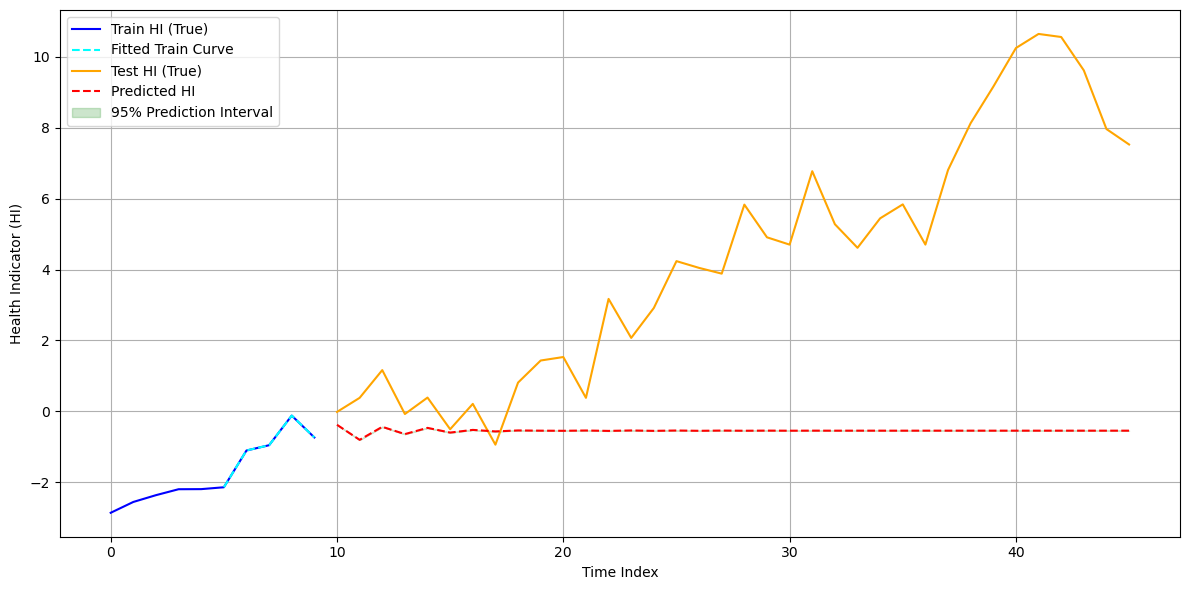

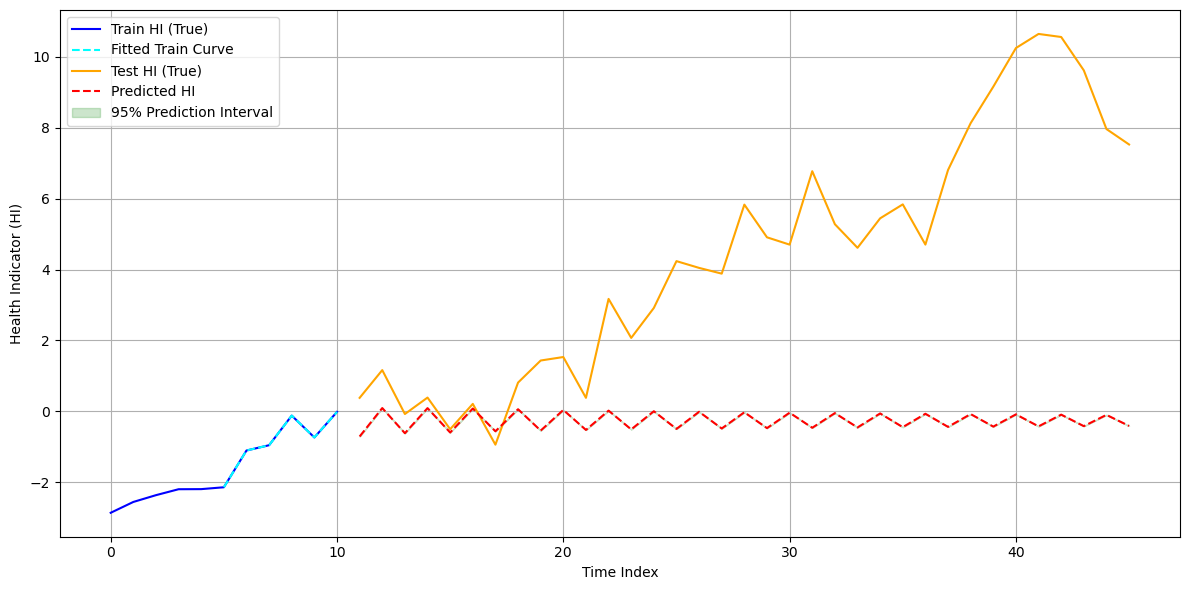

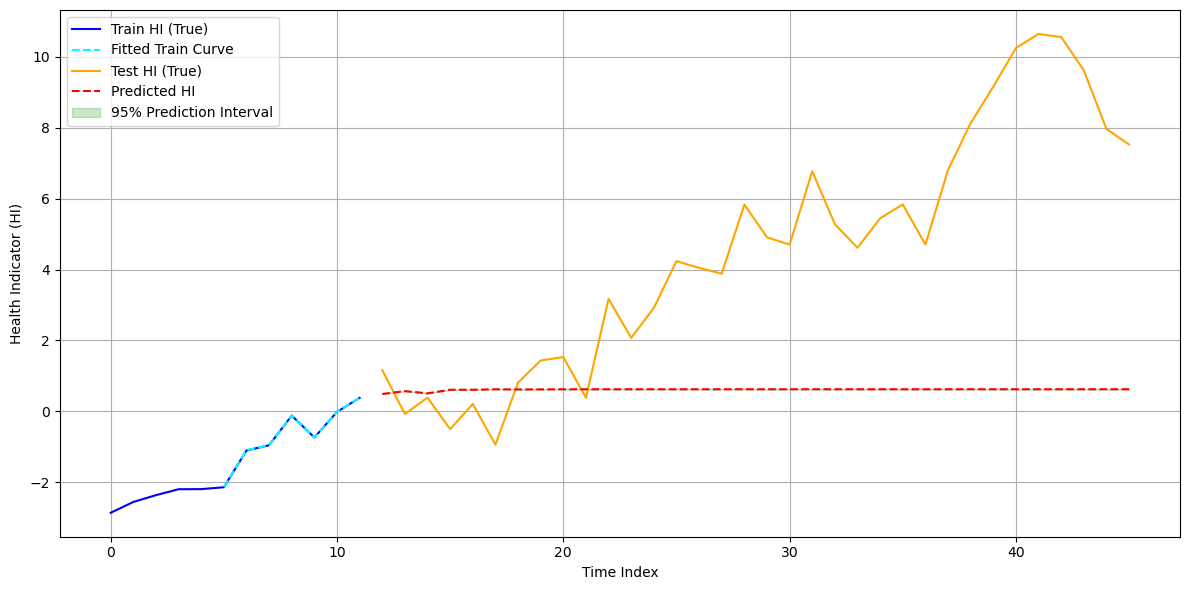

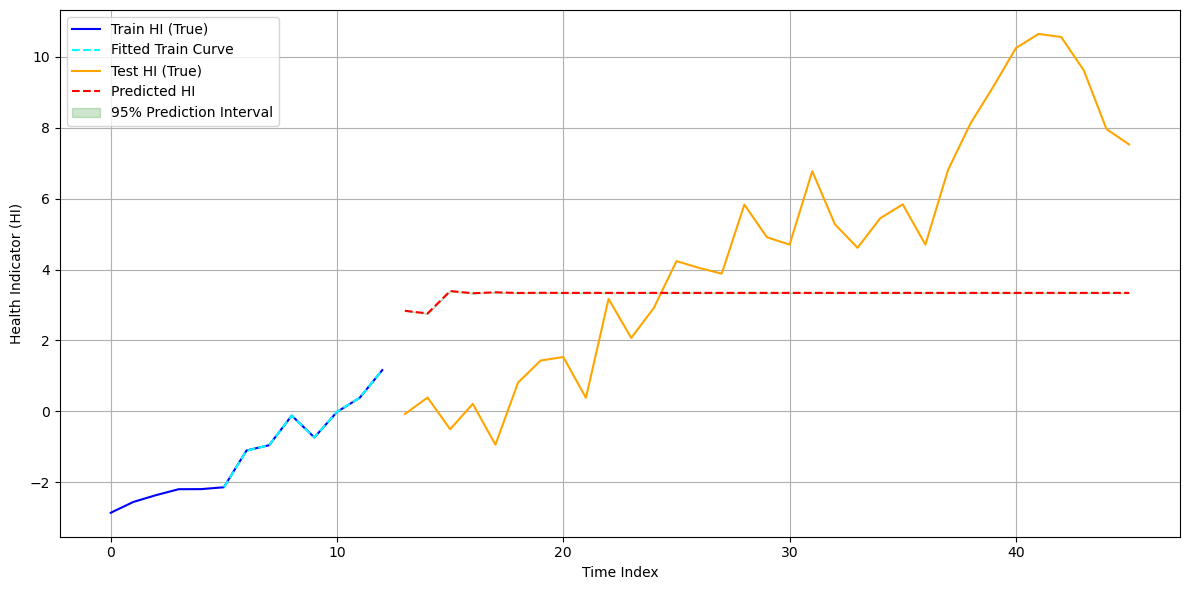

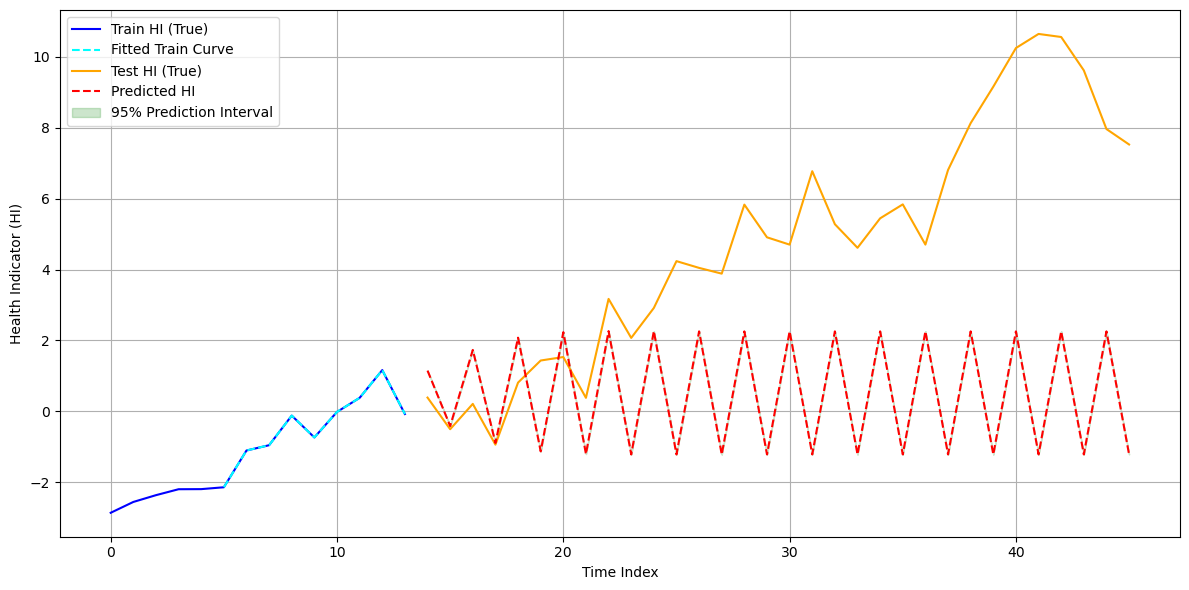

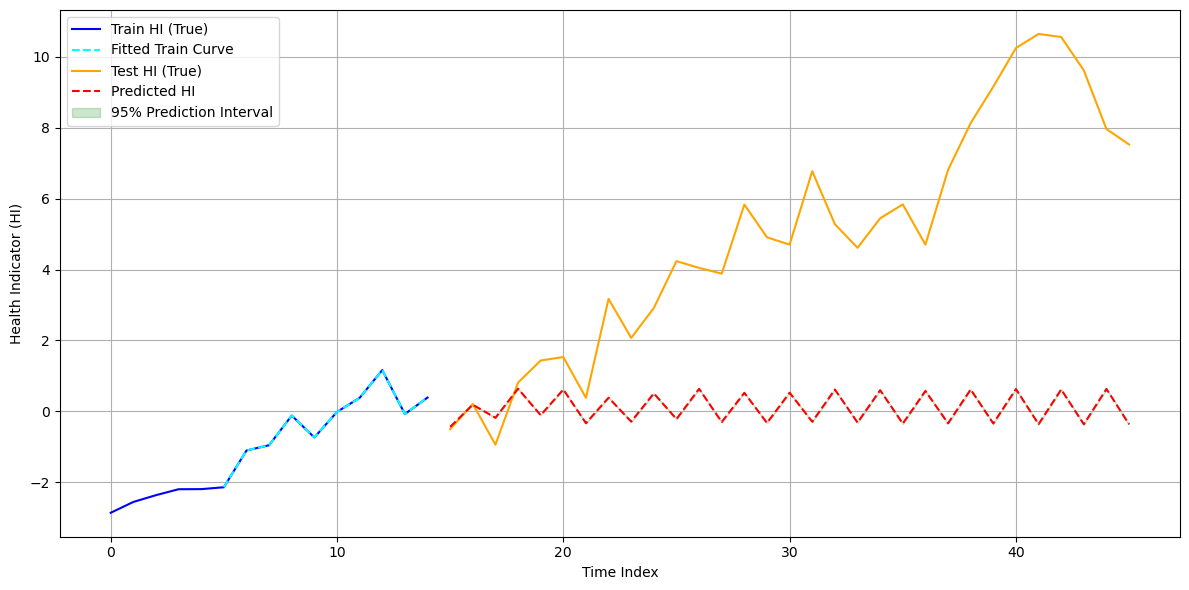

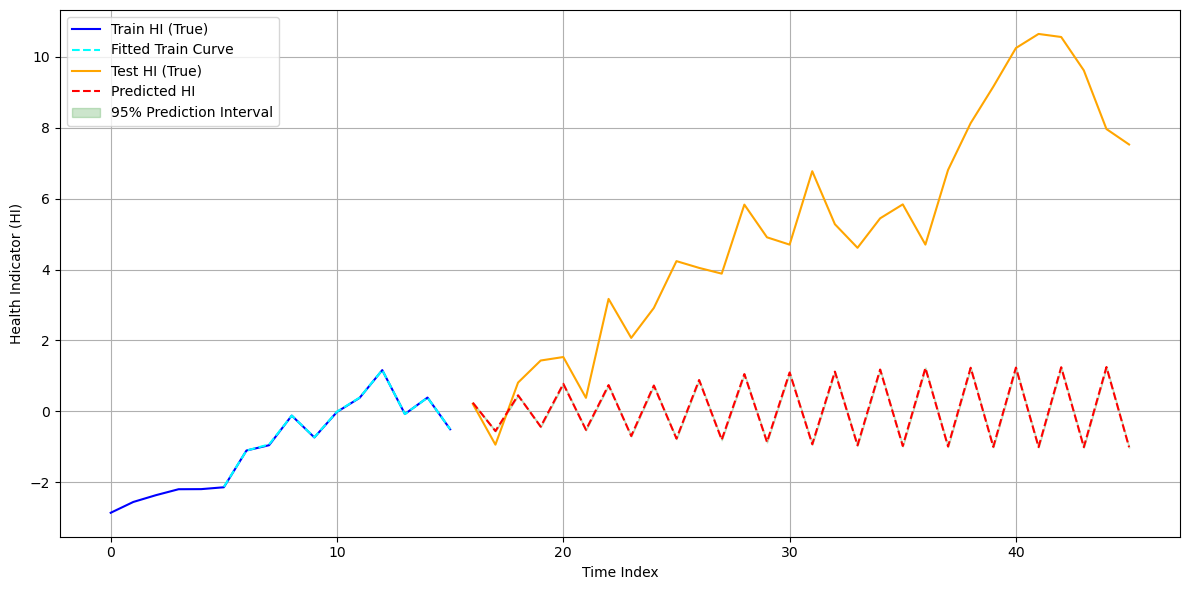

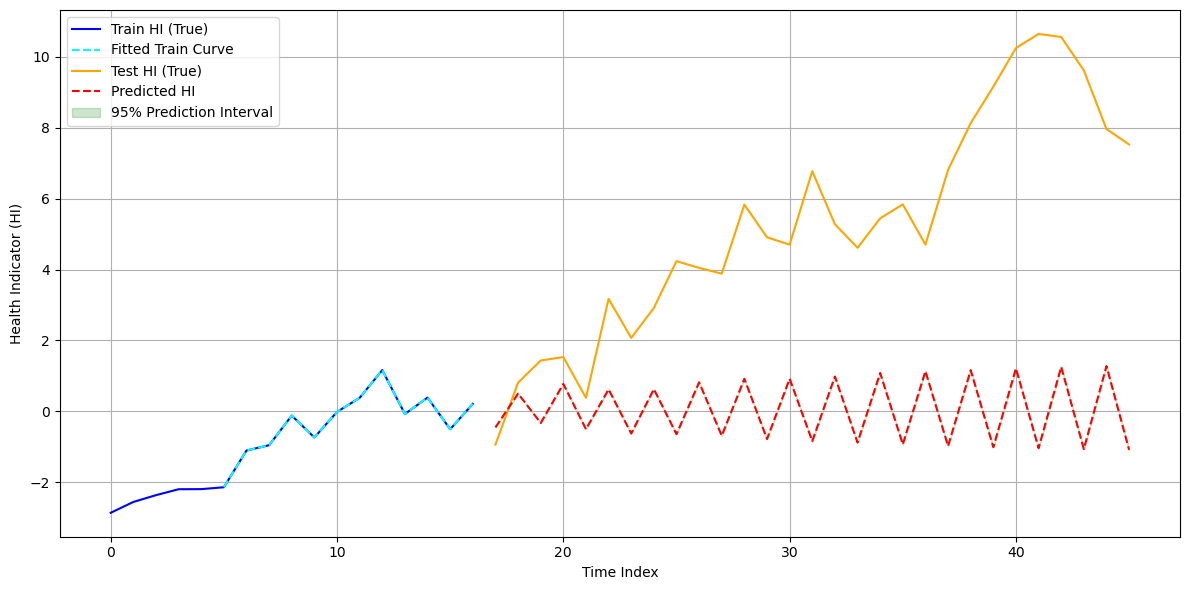

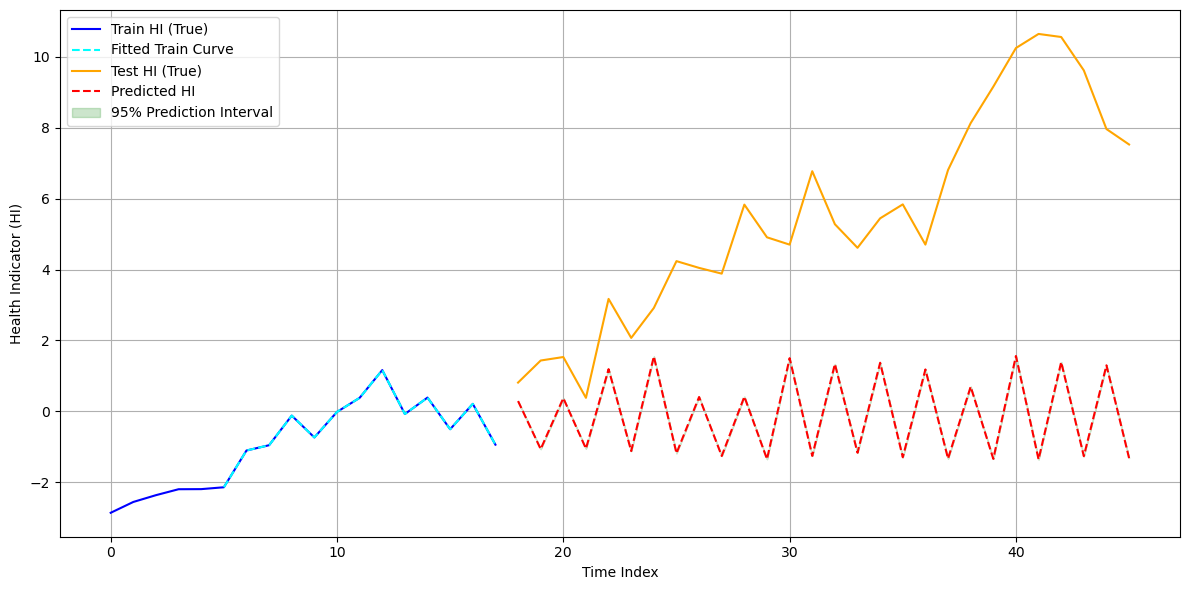

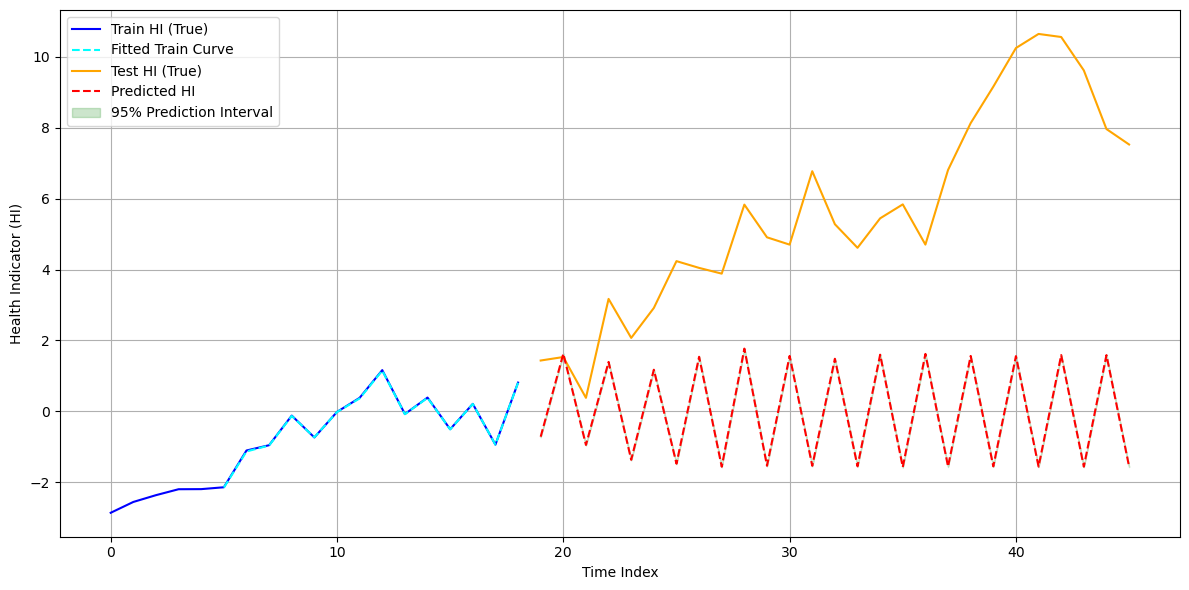

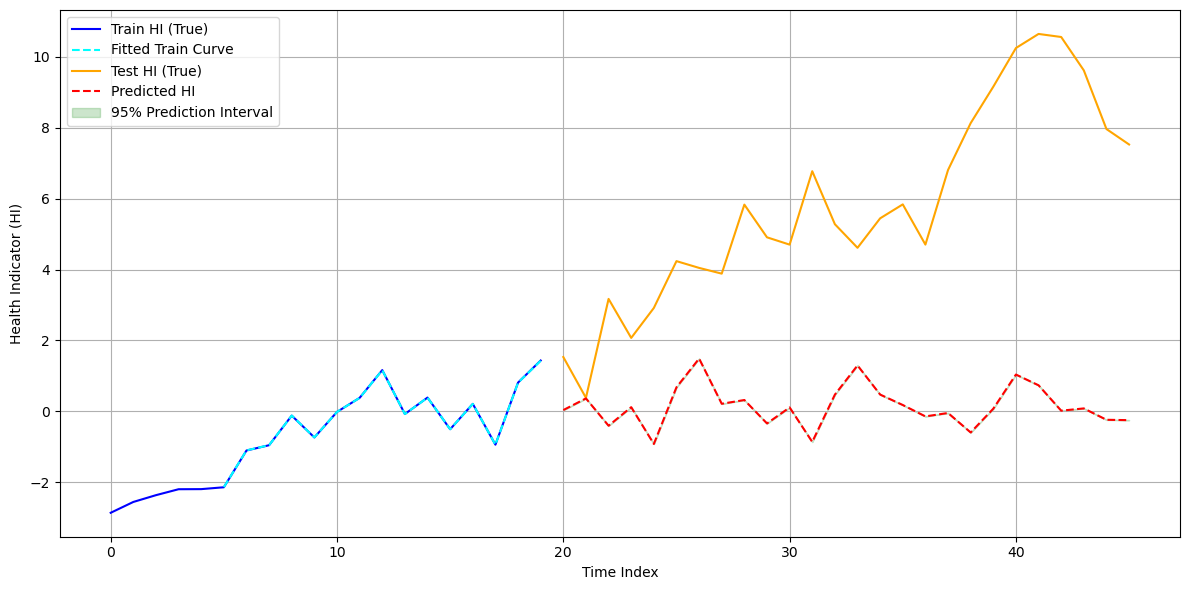

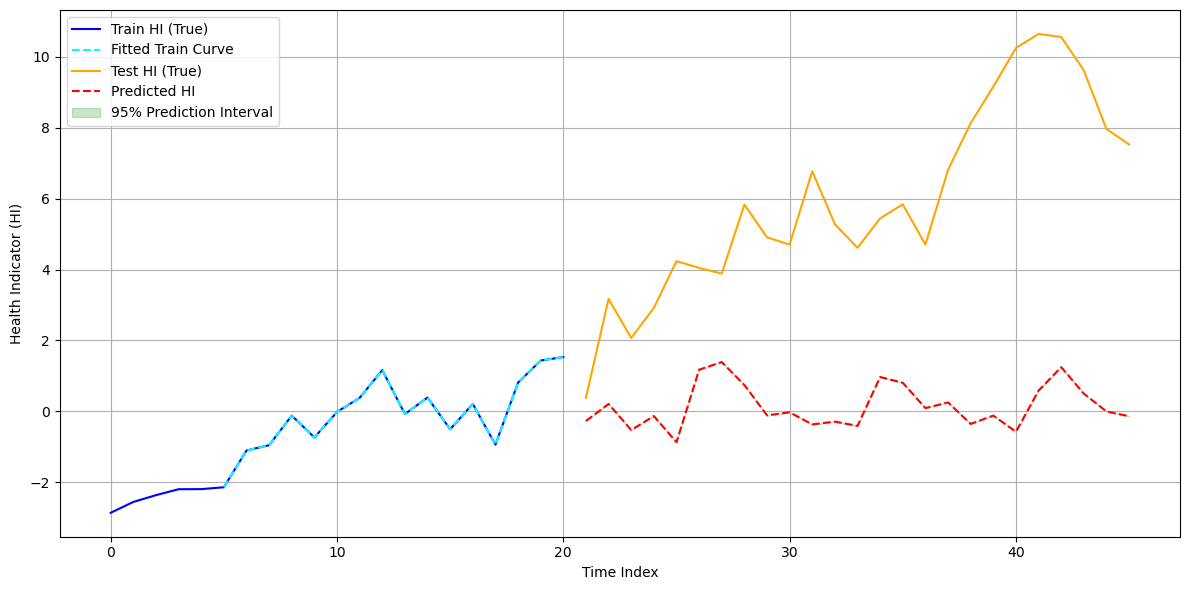

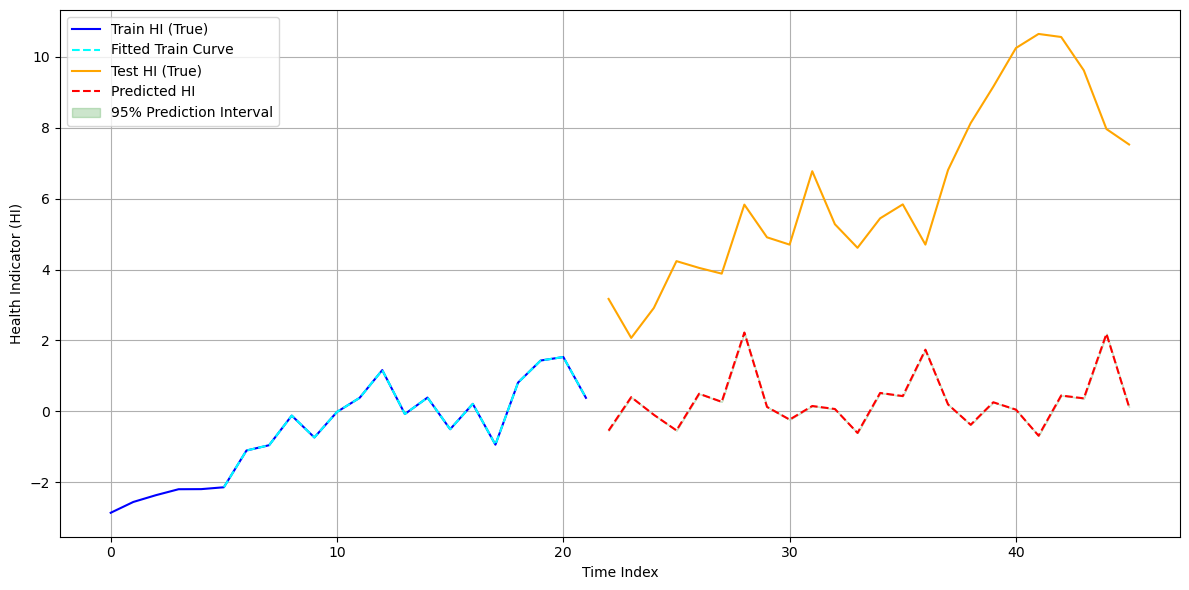

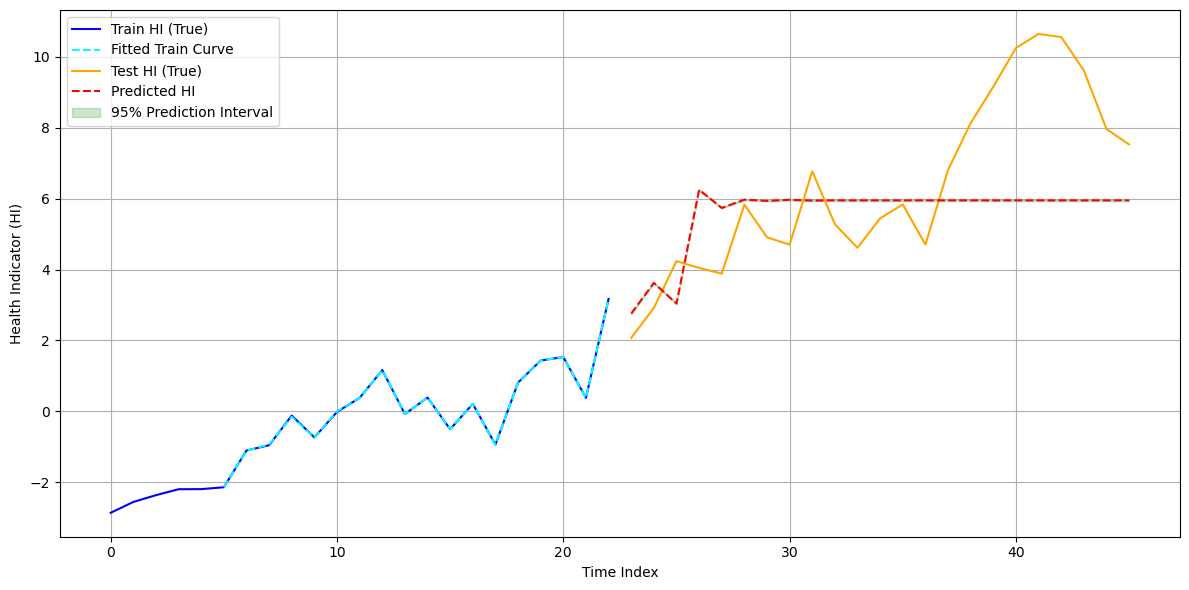

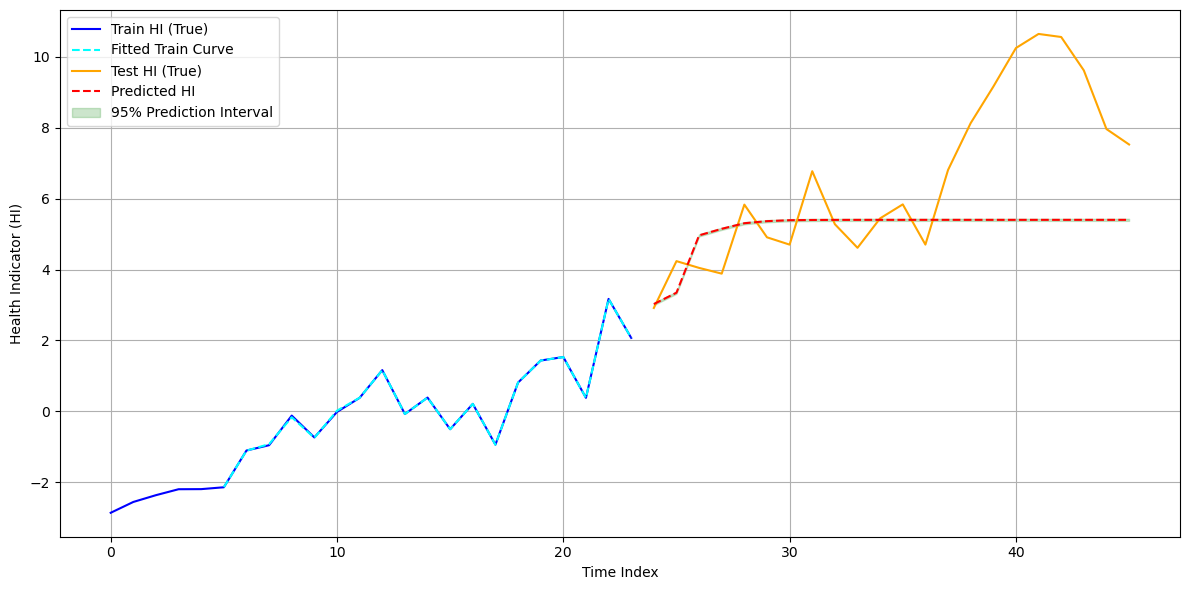

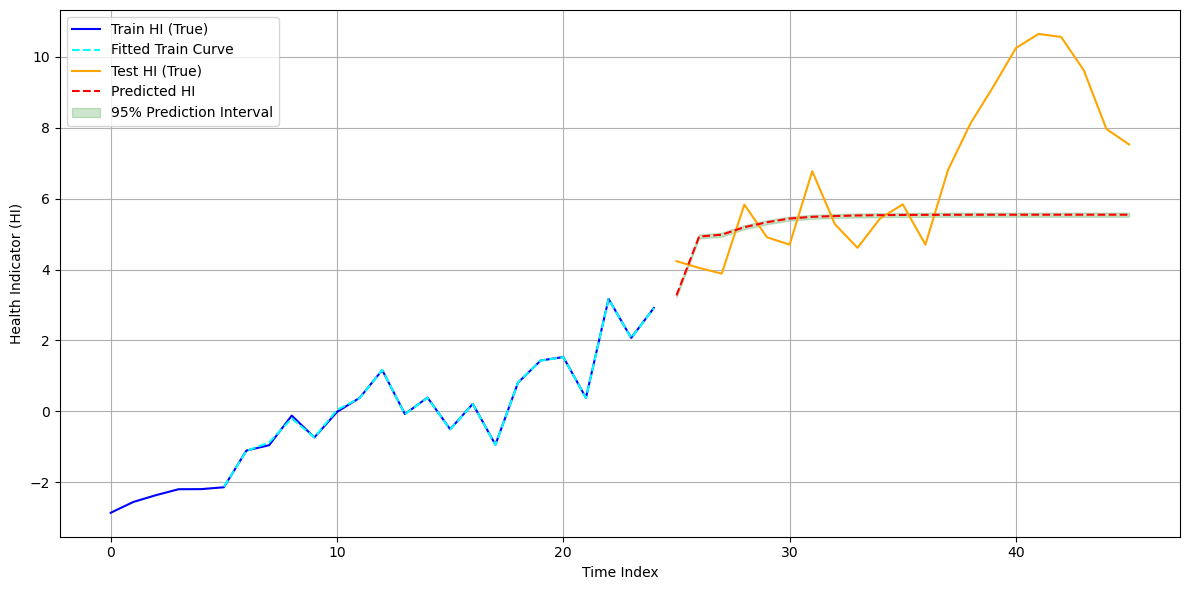

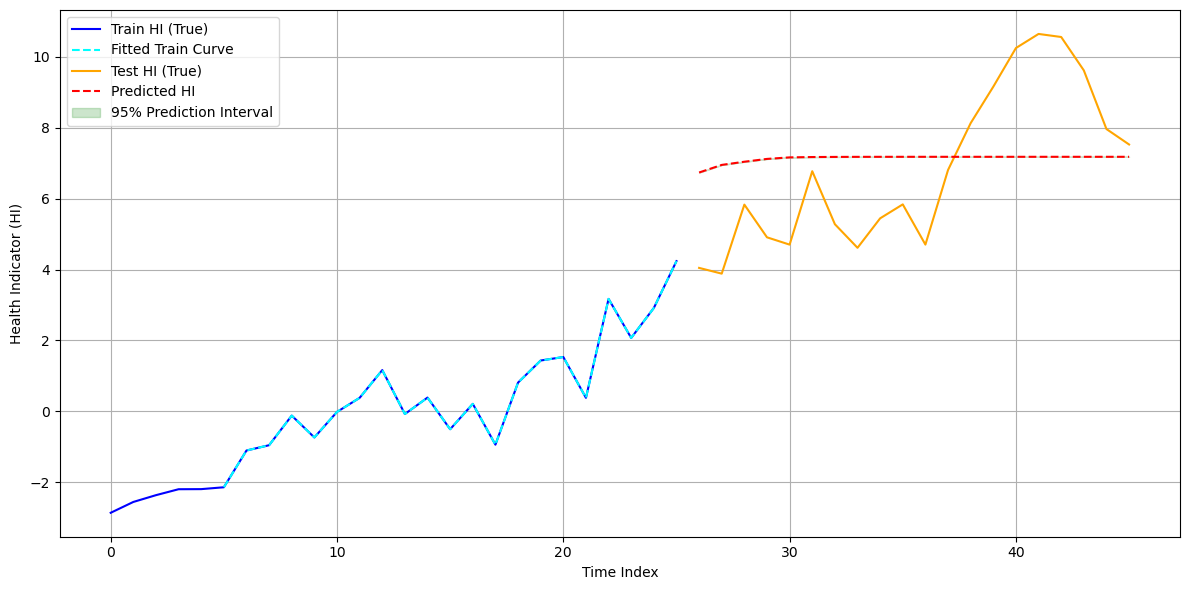

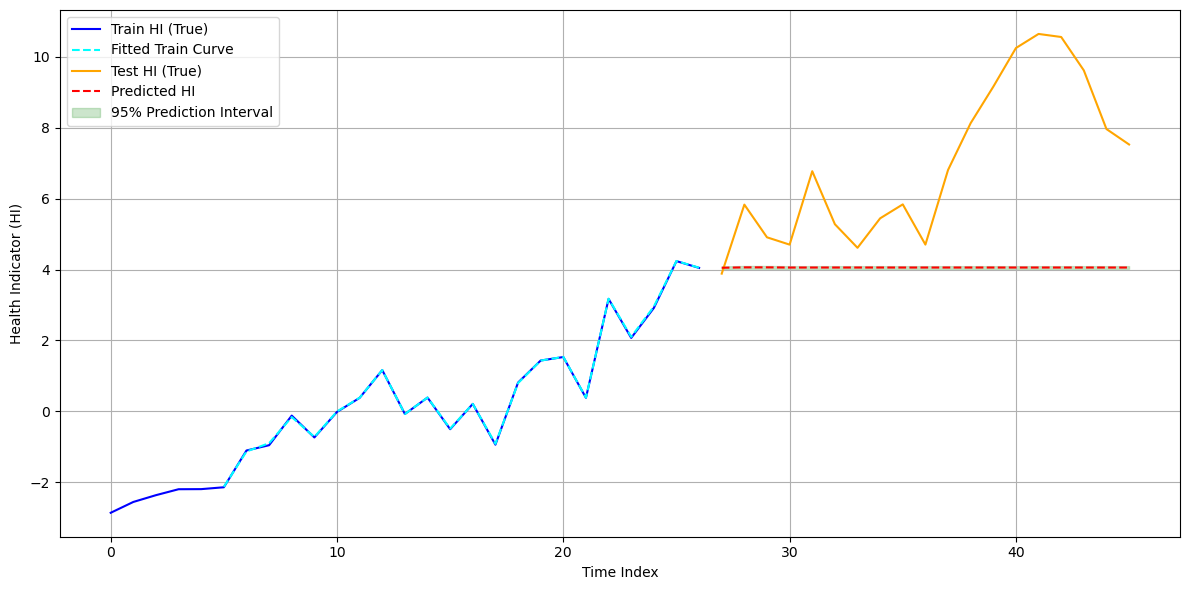

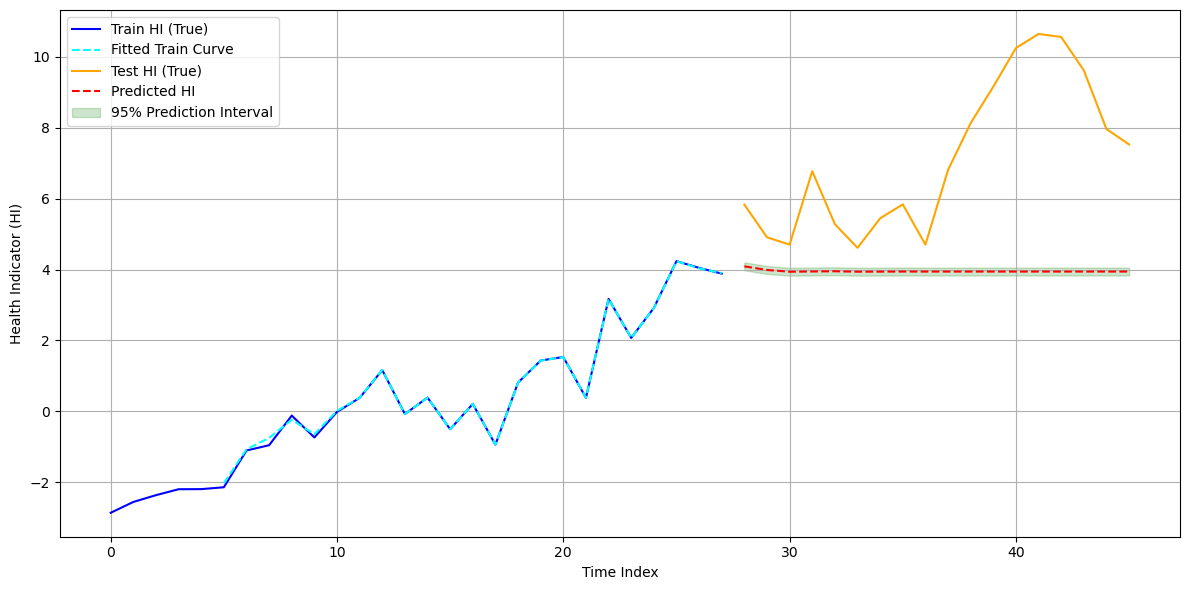

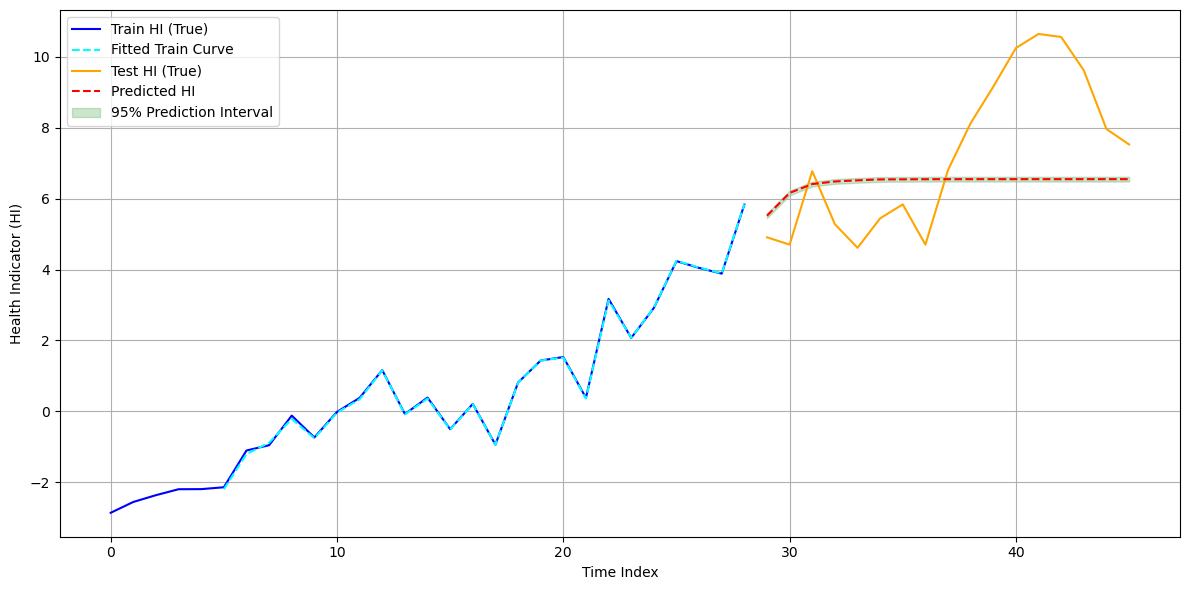

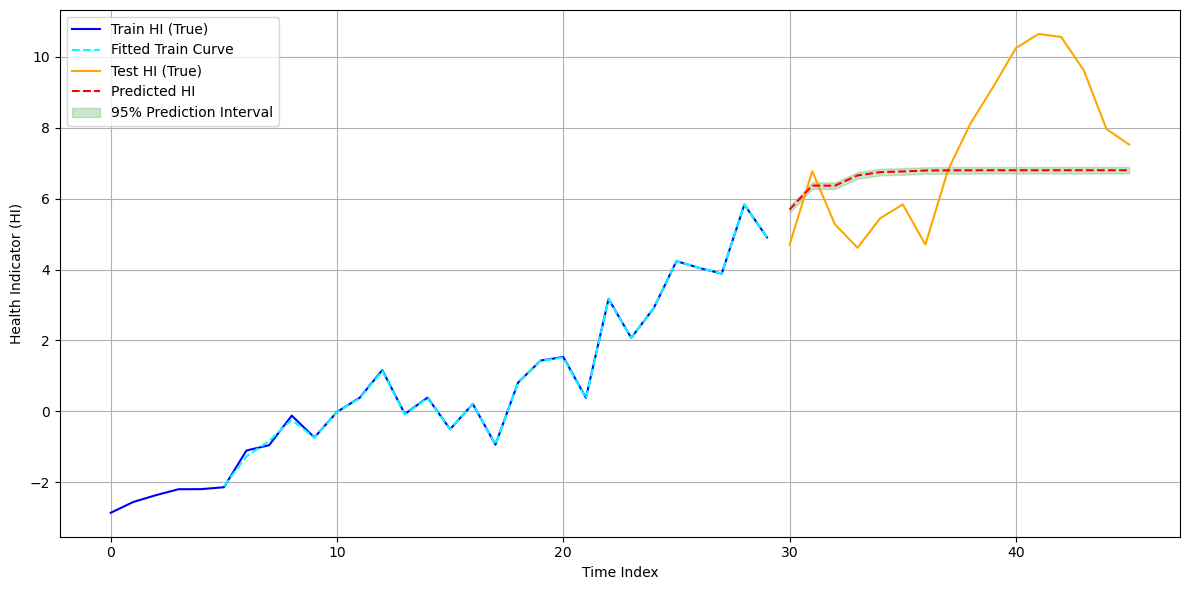

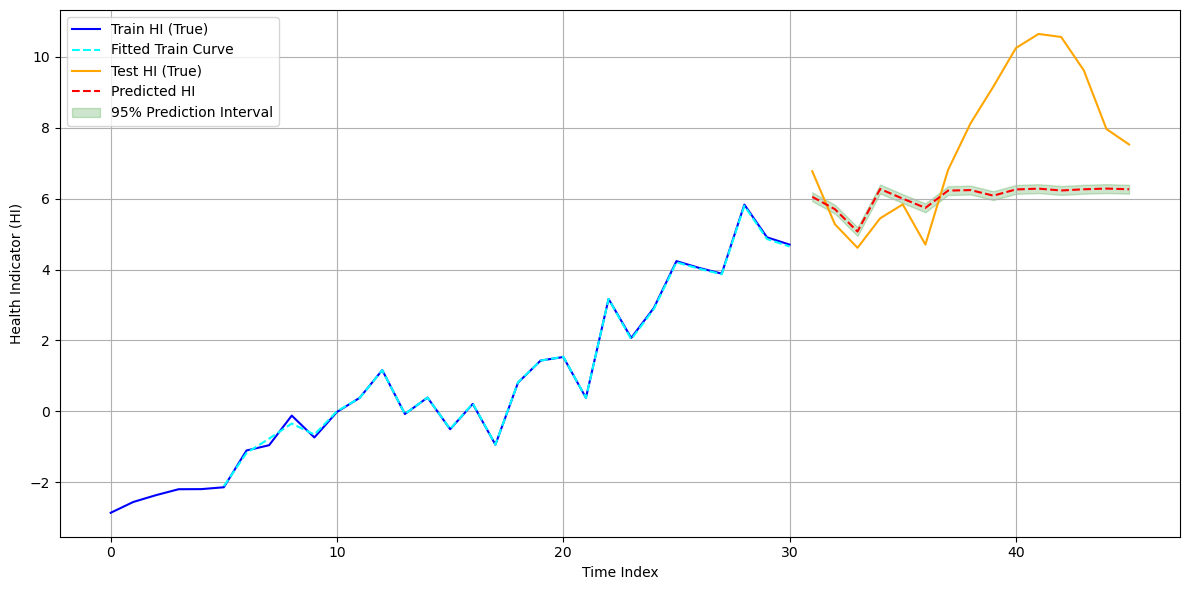

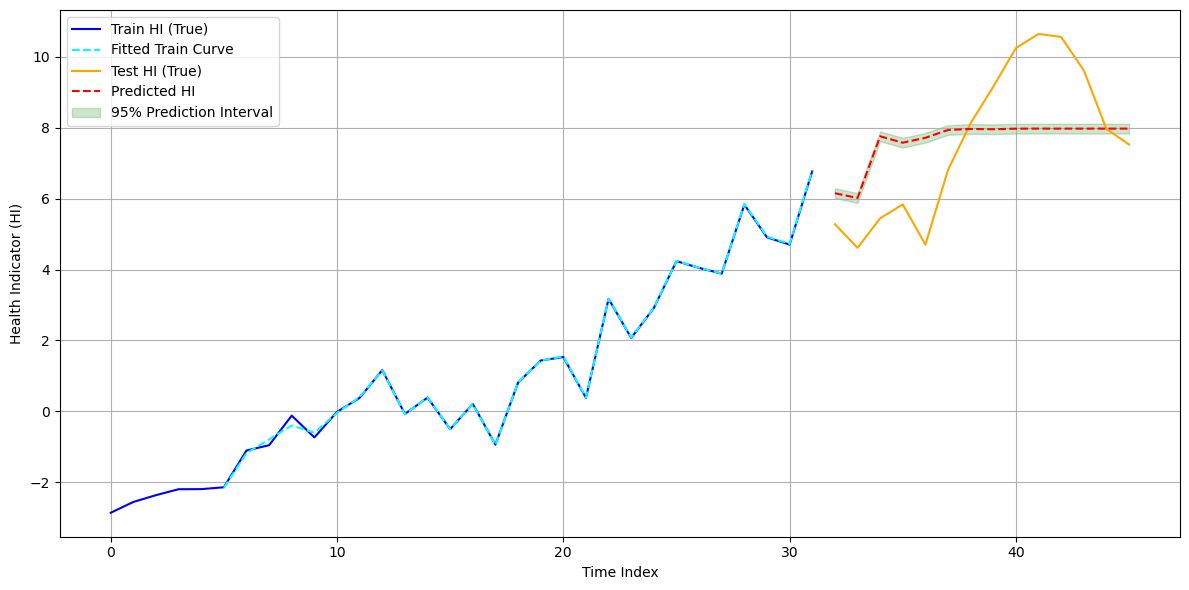

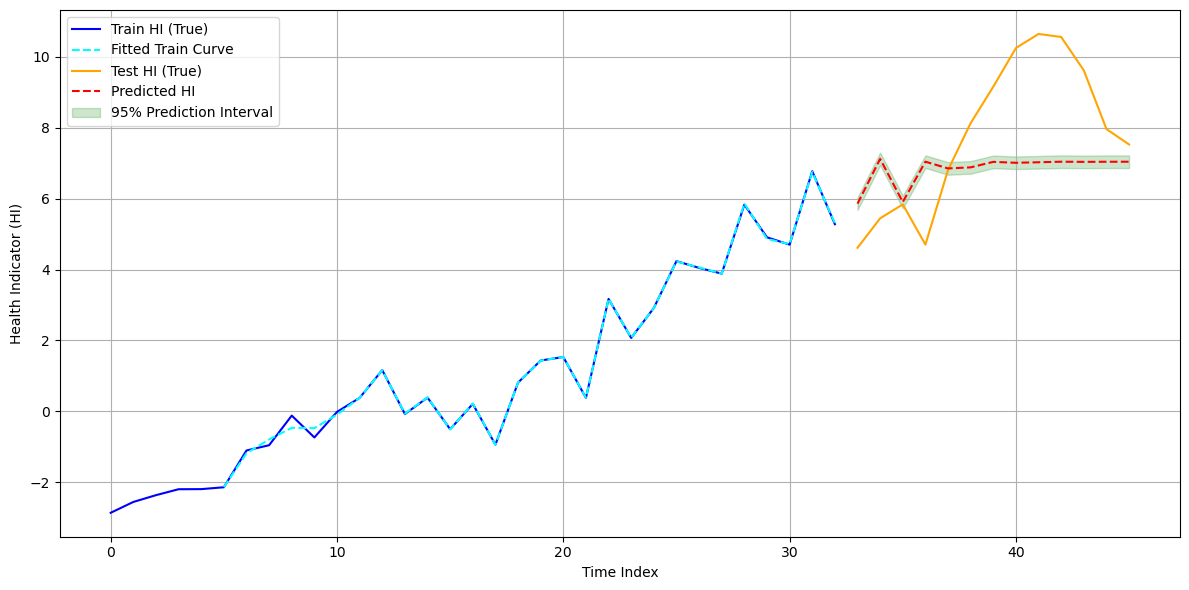

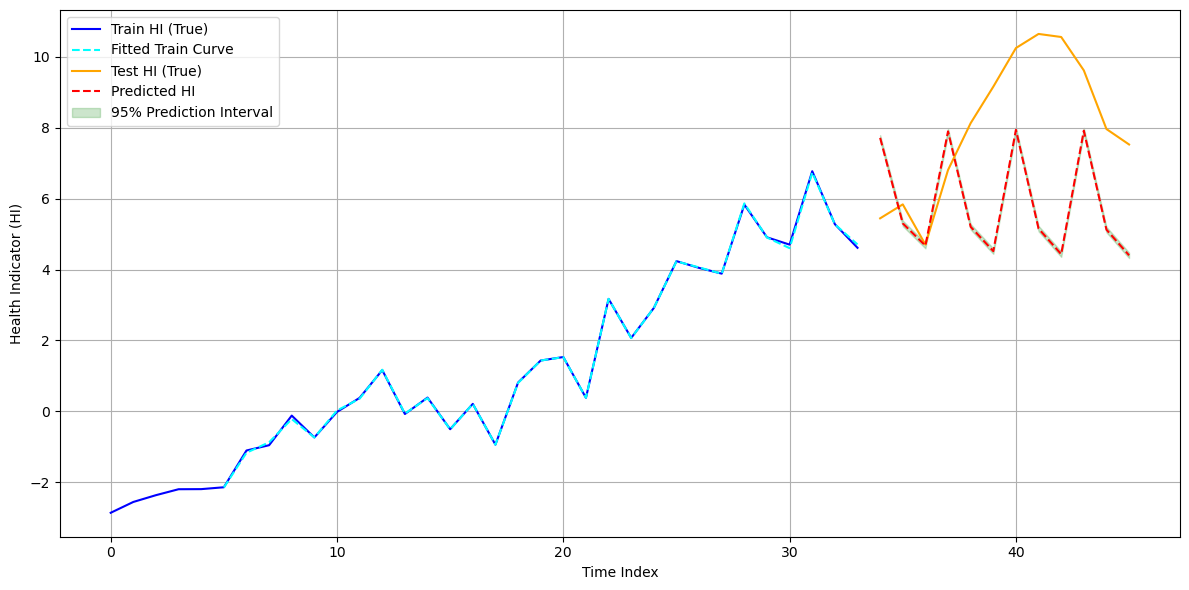

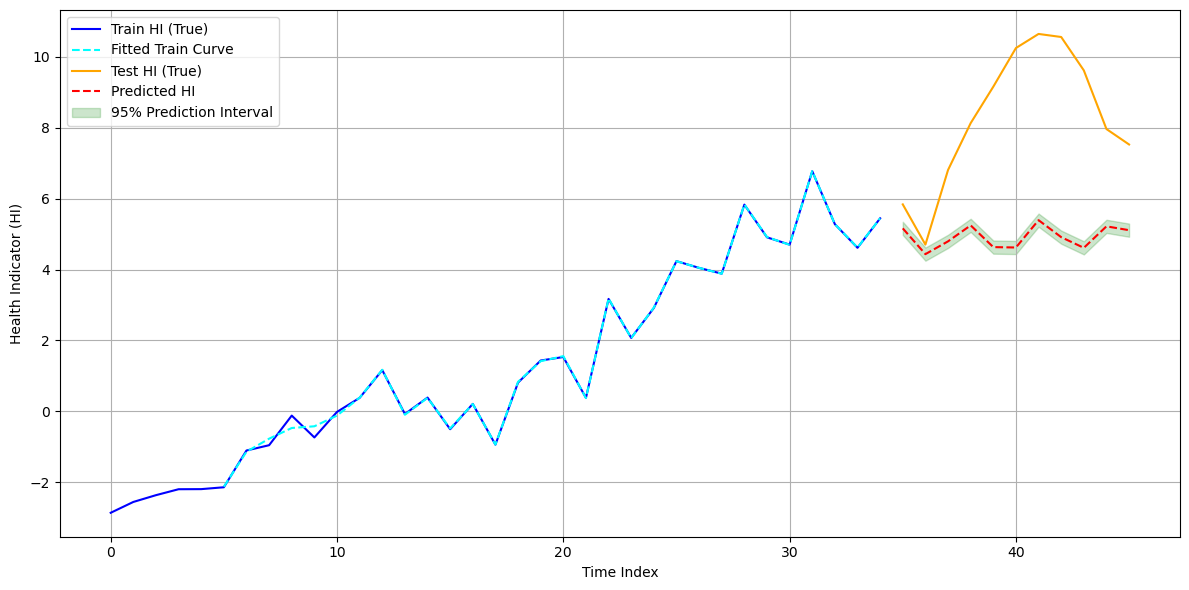

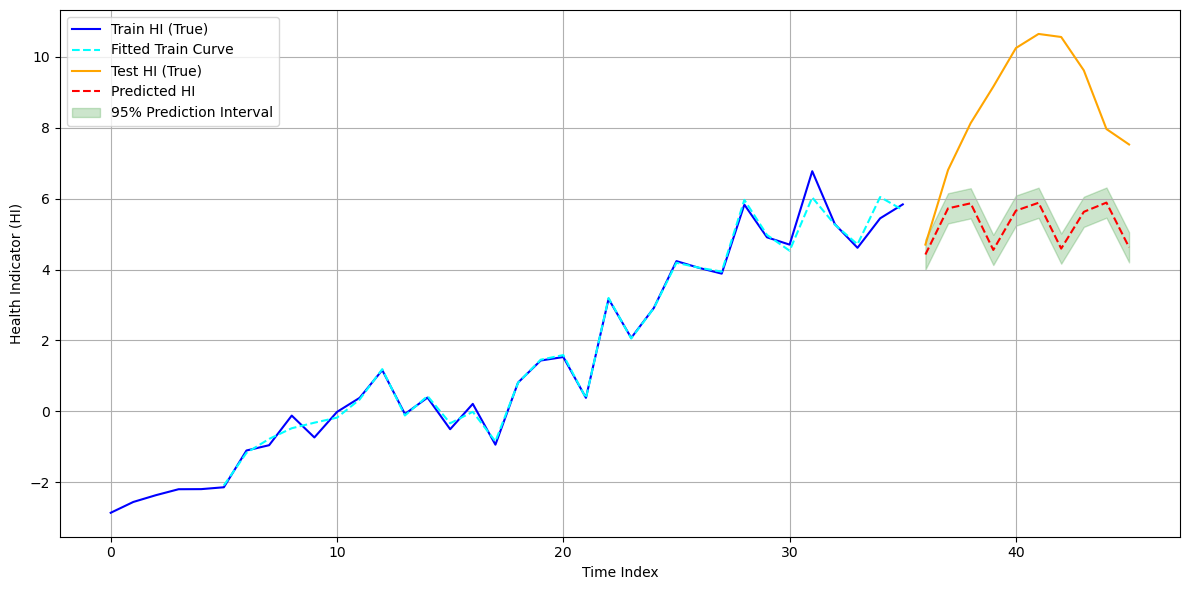

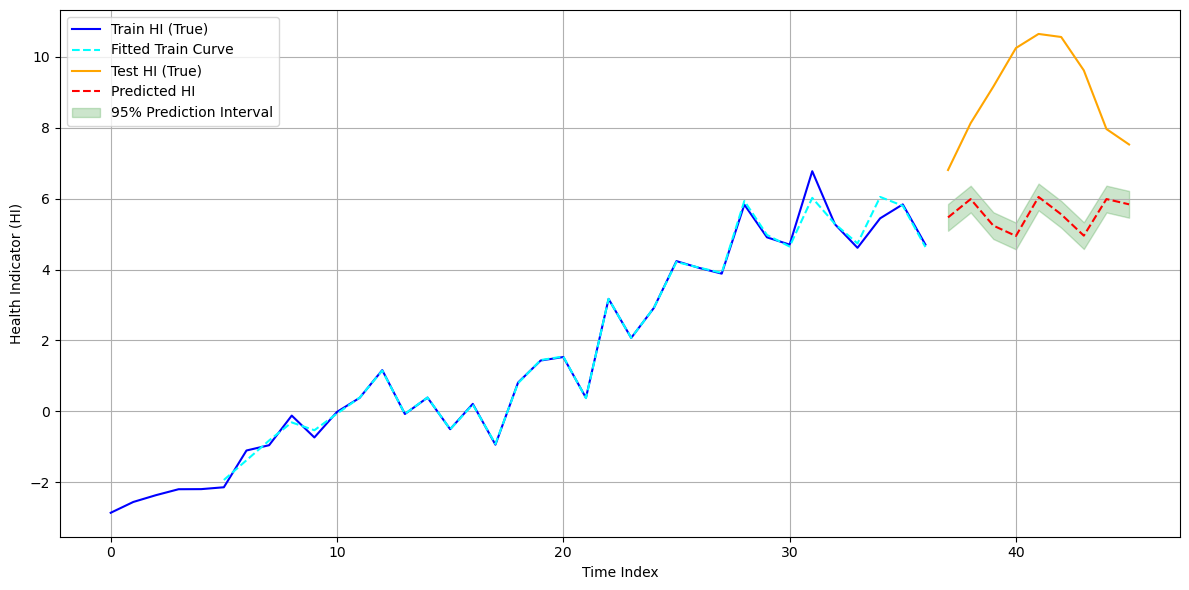

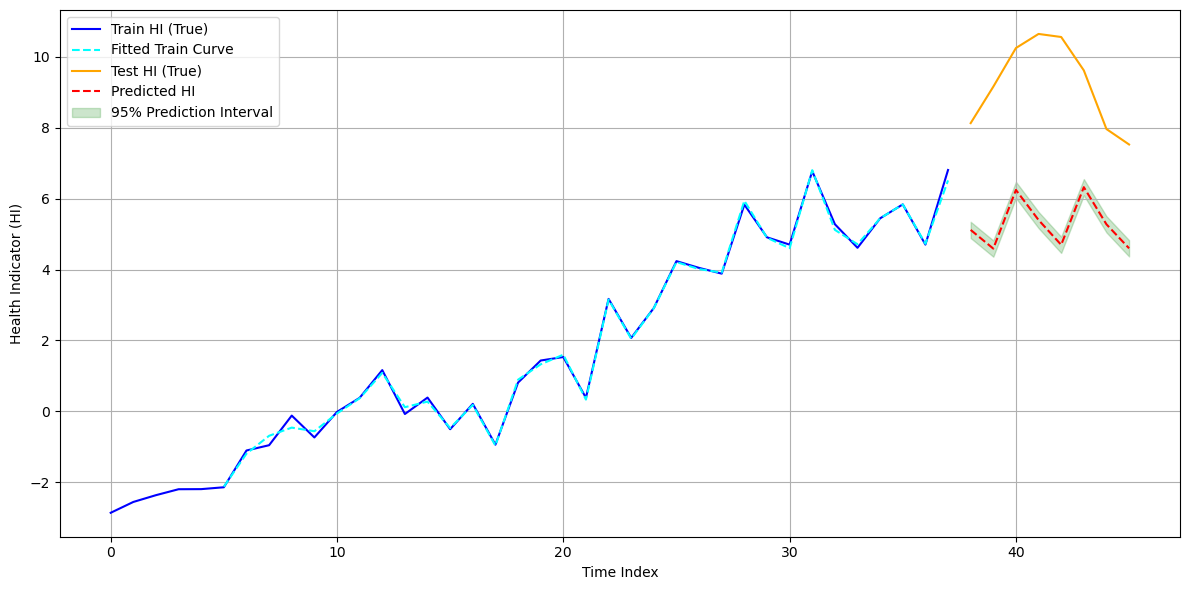

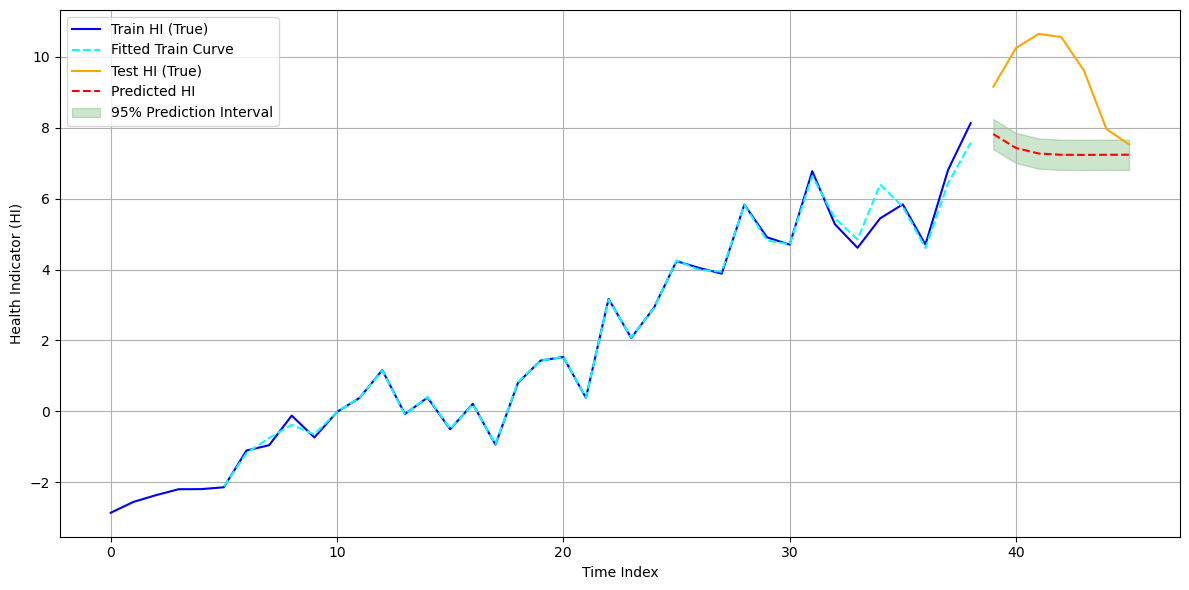

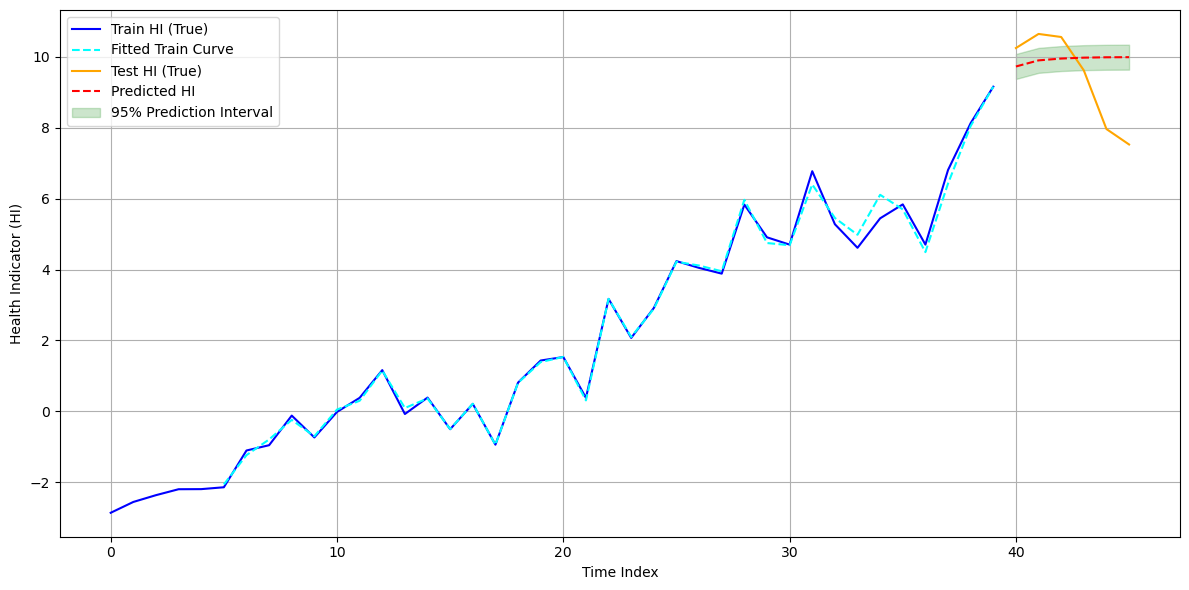

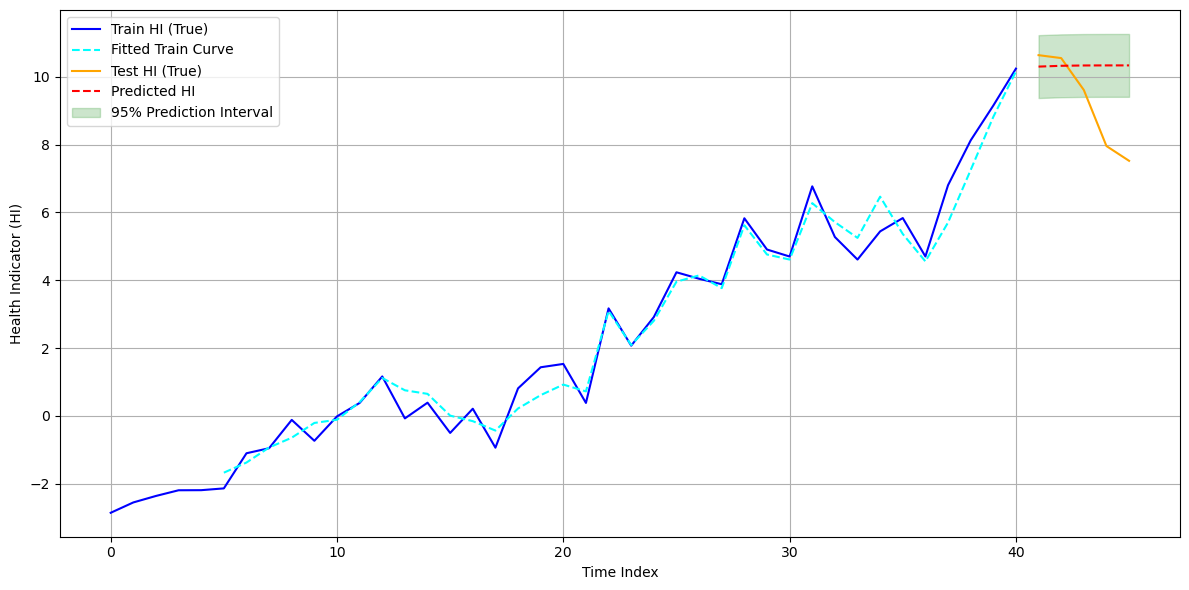

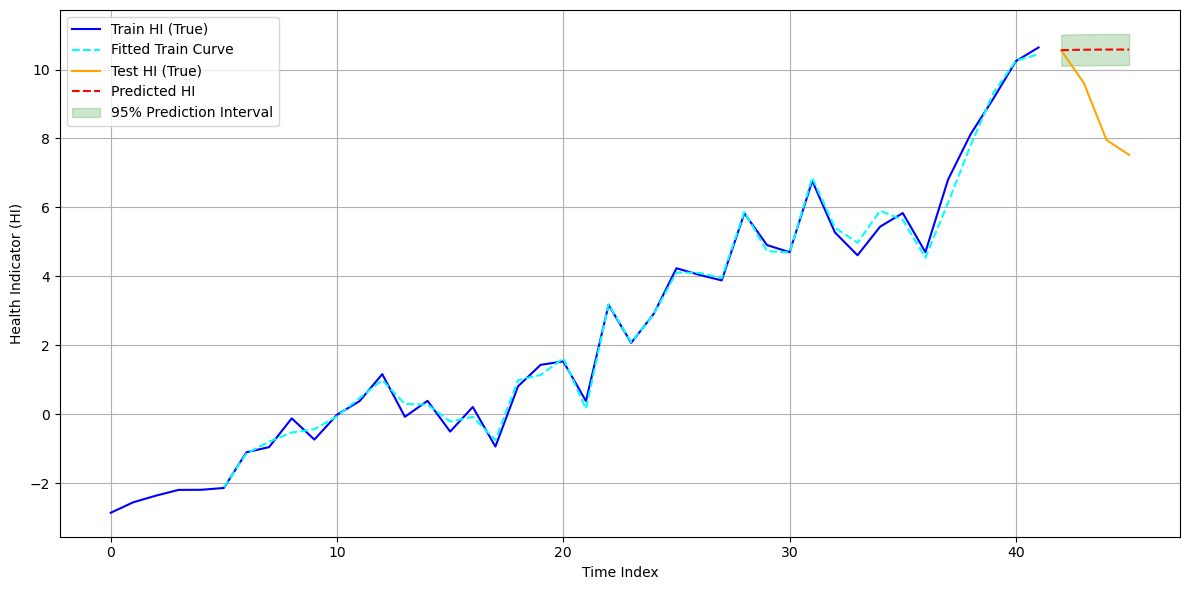

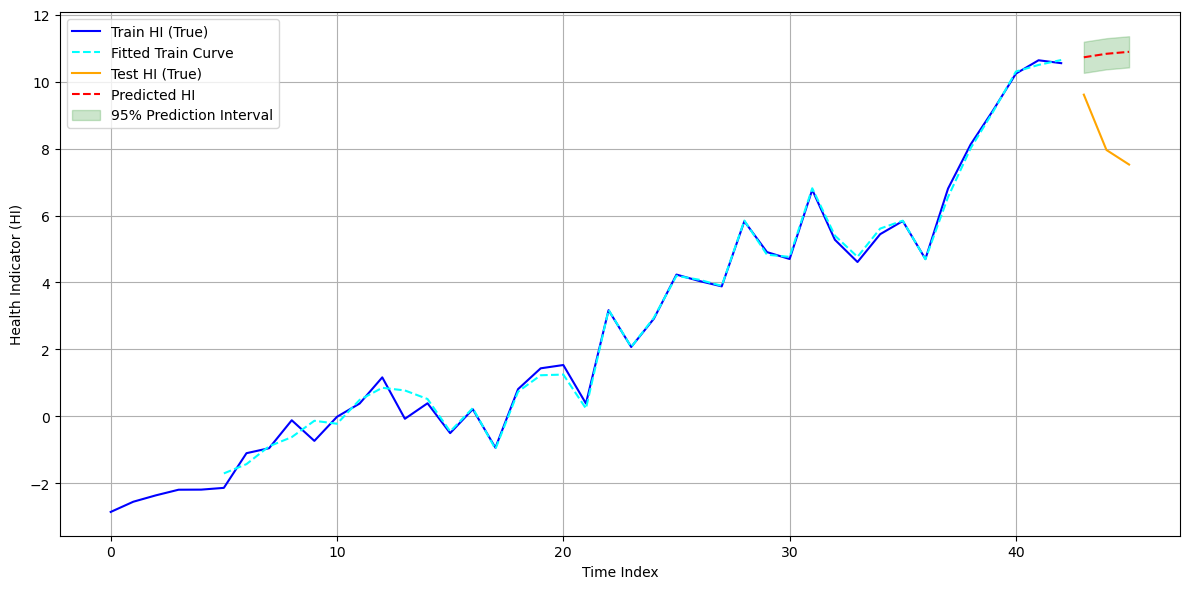

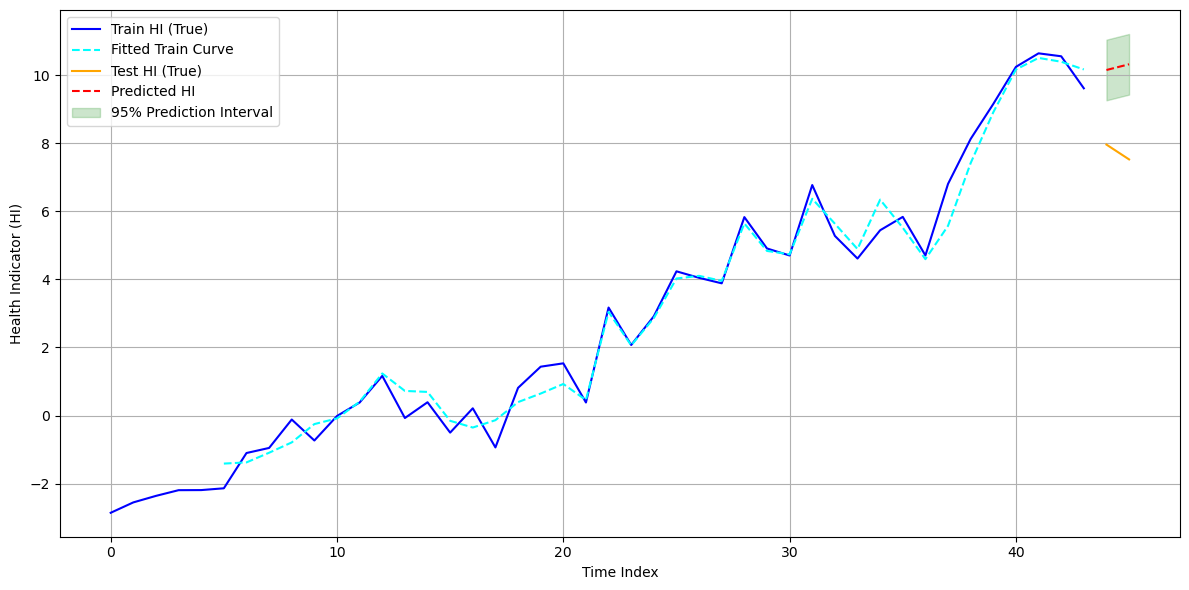

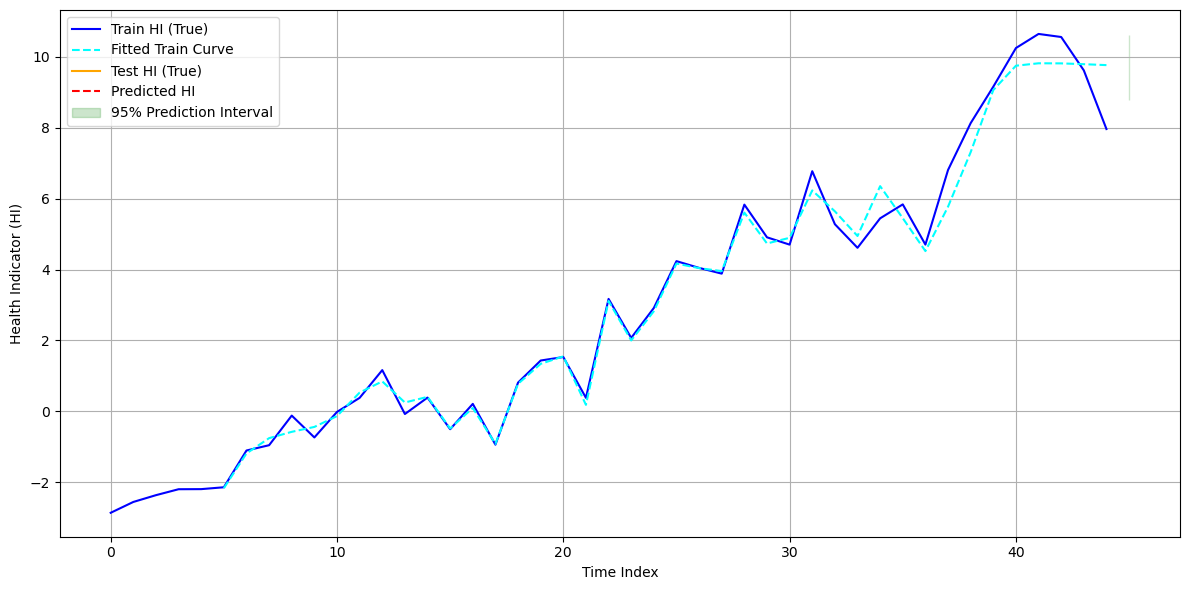

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
from IPython.display import clear_output


# --- LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only use output at last time step
        return out

# --- Sequence Creation Helper ---
def create_sequences(data, lag):
    xs, ys = [], []
    for i in range(len(data) - lag):
        x = data[i:i+lag]
        y = data[i+lag]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# --- Main Loop ---
lag_window_len = 5

train_hi, test_hi, full_hi, t_train, t_test, t_full = prepapre_HI(train_time=25)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for train_time in range(5, 46):
    train_hi, test_hi = full_hi[0:train_time], full_hi[train_time:]
    t_train, t_test = t_full[0:train_time], t_full[train_time:]

    # Create sequences
    X_train, y_train = create_sequences(train_hi, lag_window_len)

    if len(X_train) == 0:
        continue  # Skip too small train sets

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)

    # Initialize model
    model = LSTMModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train model
    model.train()
    for epoch in range(300):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    # Predict train set
    model.eval()
    with torch.no_grad():
        train_pred = []
        for i in range(len(t_train) - lag_window_len):
            input_seq = torch.tensor(train_hi[i:i+lag_window_len], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            pred = model(input_seq)
            train_pred.append(pred.item())
        # Padding first lag_window_len with NaN for alignment
        train_pred = [np.nan]*lag_window_len + train_pred

    # Predict test set
    test_pred = []
    last_window = train_hi[-lag_window_len:]  # Last known window
    for _ in range(len(t_test)):
        input_seq = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        pred = model(input_seq)
        pred_value = pred.item()
        test_pred.append(pred_value)
        # Move the window
        last_window = np.roll(last_window, -1)
        last_window[-1] = pred_value

    train_pred = np.array(train_pred)
    test_pred = np.array(test_pred)

    # Compute prediction errors on training set
    residuals = train_hi[lag_window_len:] - train_pred[lag_window_len:]
    std_error = np.std(residuals)

    # Construct 95% prediction interval (approximate)
    ci_upper = test_pred + 1.96 * std_error
    ci_lower = test_pred - 1.96 * std_error

    # Evaluate performance
    train_mse = mean_squared_error(train_hi[lag_window_len:], train_pred[lag_window_len:])
    test_mse = mean_squared_error(test_pred, test_hi)
    print(f"Train MSE: {train_mse:.4f} || Test MSE: {test_mse:.4f}")

    # Plotting
    plt.figure(figsize=(12, 6))

    # True HI - training
    plt.plot(t_train, train_hi, label='Train HI (True)', color='blue')
    plt.plot(t_train, train_pred, label='Fitted Train Curve', color='cyan', linestyle='--')

    # True HI - test
    plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
    plt.plot(t_test, test_pred, label='Predicted HI', color='red', linestyle='--')

    # Prediction interval
    plt.fill_between(t_test, ci_lower, ci_upper, color='green', alpha=0.2, label='95% Prediction Interval')

    plt.xlabel('Time Index')
    plt.ylabel('Health Indicator (HI)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # ADD THE SAVING CODE HERE
if epoch % 10 == 0 or epoch == num_epochs-1:  # Save every 10 epochs and final epoch
    plt.savefig(f'hi_prediction_epoch_{epoch}.png', dpi=300, bbox_inches='tight')
    clear_output(wait=True)
    plt.savefig('high_res_plot.png', dpi=900, bbox_inches='tight', format='png')
    plt.show()
    time.sleep(0.5)

# Add this line right after the for loop ends (after the time.sleep(0.5) line)
    print(f"Final results - Train MSE: {train_mse:.4f} || Test MSE: {test_mse:.4f}")


# Prophet Model

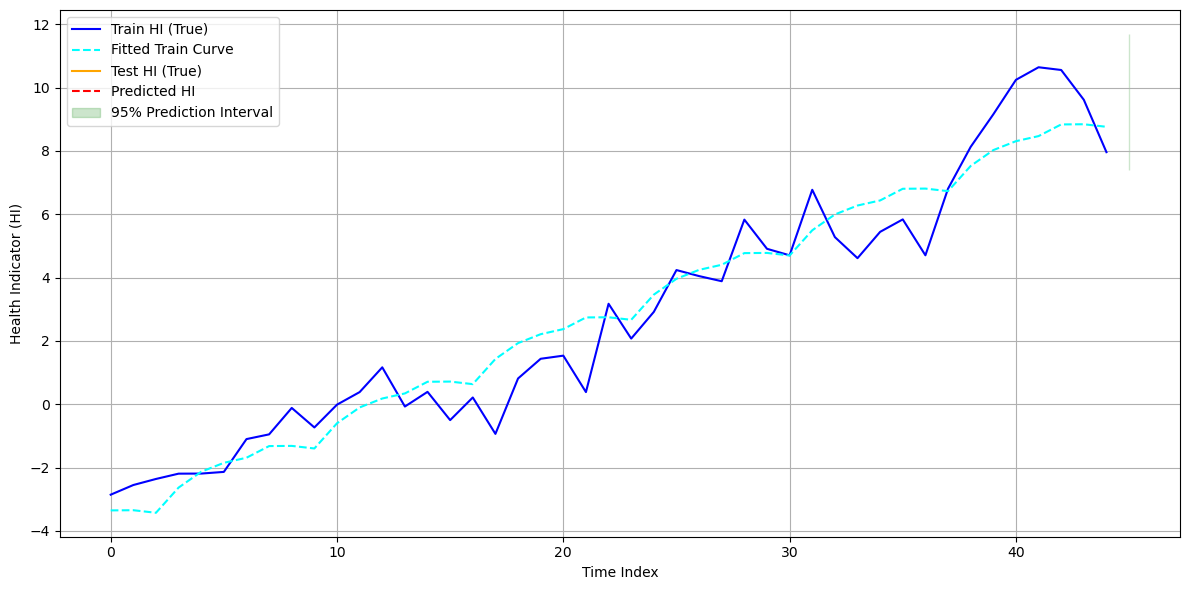

In [21]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
import time

# Suppose prepapre_HI is already defined
train_hi, test_hi, full_hi, t_train, t_test, t_full = prepapre_HI(train_time=25)

lag_window_len = 5

for train_time in range(5, 46):
    train_hi, test_hi = full_hi[0:train_time], full_hi[train_time:]
    t_train, t_test = t_full[0:train_time], t_full[train_time:]

    # -------- Prepare training DataFrame for Prophet --------
    df_train = pd.DataFrame({
        'ds': pd.to_datetime(t_train, unit='D'),  # Prophet needs datetime type
        'y': train_hi
    })

    # -------- Train Prophet model --------
    model = Prophet(interval_width=0.95)
    model.fit(df_train)

    # -------- Prepare future DataFrame --------
    df_future = pd.DataFrame({
        'ds': pd.to_datetime(t_test, unit='D')  # Future points (test set)
    })

    # -------- Make Predictions --------
    forecast = model.predict(df_future)

    test_pred = forecast['yhat'].values
    ci_lower = forecast['yhat_lower'].values
    ci_upper = forecast['yhat_upper'].values

    # -------- Compute metrics --------
    df_train_pred = model.predict(df_train)
    train_pred = df_train_pred['yhat'].values

    train_mse = mean_squared_error(train_hi, train_pred)
    test_mse = mean_squared_error(test_hi, test_pred)
    print(f"Train MSE: {train_mse:.4f} || Test MSE: {test_mse:.4f}")

    # -------- Plotting --------
    plt.figure(figsize=(12, 6))

    # True HI - training
    plt.plot(t_train, train_hi, label='Train HI (True)', color='blue')
    plt.plot(t_train, train_pred, label='Fitted Train Curve', color='cyan', linestyle='--')

    # True HI - test
    plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
    plt.plot(t_test, test_pred, label='Predicted HI', color='red', linestyle='--')

    # Prediction interval
    plt.fill_between(t_test, ci_lower, ci_upper, color='green', alpha=0.2, label='95% Prediction Interval')

    plt.xlabel('Time Index')
    plt.ylabel('Health Indicator (HI)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    clear_output(wait=True)
    plt.show()
    
    time.sleep(0.5)


# RUL Prediction Using Prophet Model as It is clearly better than LSTM

## Handling PCA Stability for RUL Prediction
When performing Remaining Useful Life (RUL) prediction, it is essential to fix a reference PCA (Principal Component Analysis) value beforehand. This is because if we continuously update the PCA while predicting RUL, the principal components themselves keep shifting as new data comes in. As a result, we cannot define a consistent threshold or baseline for monitoring the system’s degradation.

To address this issue, we assume access to historical sensor data for a fixed time window—for example, the last 25 days. We compute the PCA using only this fixed dataset. By doing so, we stabilize the transformation space and ensure that the subsequent RUL predictions are based on a consistent feature representation.

The approach involves the following steps:

- Assume access to historical data from the previous 25 days.

- Compute PCA based on this 25-day window.

- Normalize incoming data using the statistics derived from this fixed PCA.

- Predict future RUL (or IUL, if modeling the inverse) using the stable, transformed features.

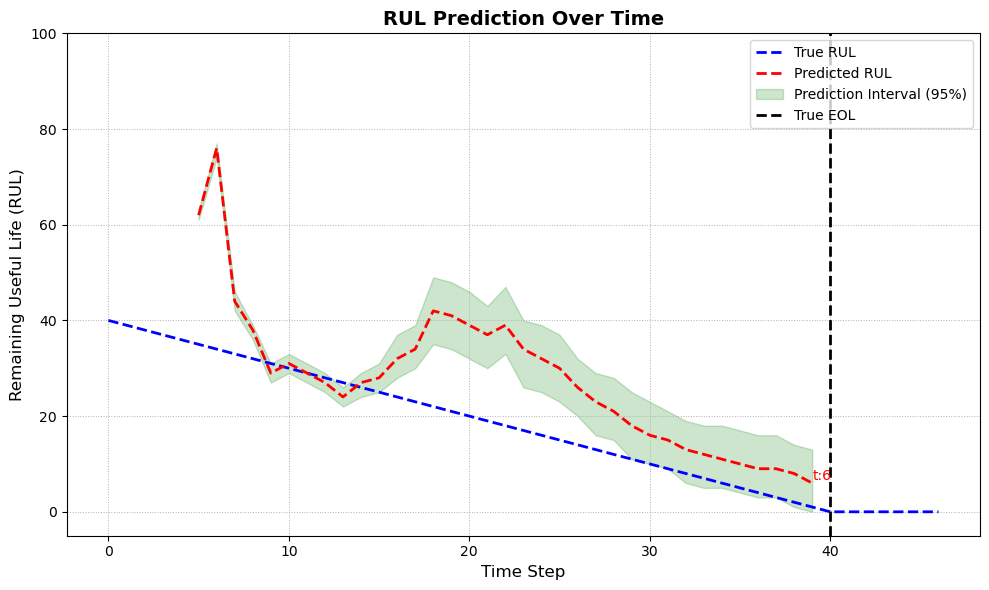

18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing


--- Prediction Analysis at Day 40 ---
Median Predicted RUL: 4.0 days (Predicted EOL at Day 44)
95% Prediction Interval for RUL: [11.0, -2.0] days
This implies a ~2.5% likelihood of failure occurring before Day 51.
--------------------------------------------------



In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
import time

train_hi, test_hi, full_hi, t_train, t_test, t_full = prepapre_HI(train_time=25)
analysis_results = []
threshold = 8.5  # Define the threshold for failure
predicted_ruls = []
predicted_ruls_upper = []
predicted_ruls_lower = []

time_steps = np.concatenate((t_train, t_test), axis=0)
health_indicators = np.concatenate((train_hi, test_hi), axis=0)
true_ruls = time_steps[np.where(health_indicators > threshold)][0] - time_steps
true_EOL = time_steps[np.where(health_indicators > threshold)][0]
true_ruls[true_ruls < 0] = 0  # Set negative RULs to zero

time_range = np.arange(1, 100, 1)

# Prepare a fake starting date
start_date = pd.to_datetime('2020-01-01')  # Arbitrary

# Map time indices to datetime
time_mapping = {i: start_date + pd.Timedelta(days=int(i)) for i in range(0, 100)}

t_start, t_end = 5, 46
for current_time in range(t_start, t_end):

    train_hi = full_hi[0:current_time]
    t_train = t_full[0:current_time]

    # ----------- Prepare training DataFrame for Prophet -----------
    df_train = pd.DataFrame({
        'ds': [time_mapping[i] for i in t_train],
        'y': train_hi
    })

    # ----------- Train Prophet model -----------
    model = Prophet(interval_width=0.95, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=False)
    model.fit(df_train)

    # ----------- Prepare future DataFrame -----------
    df_future = pd.DataFrame({
        'ds': [time_mapping[i] for i in time_range]
    })

    # ----------- Make predictions -----------
    forecast = model.predict(df_future)
    HI_time_range = forecast['yhat'].values
    hi_upper = forecast['yhat_upper'].values
    hi_lower = forecast['yhat_lower'].values

    # ----------- Compute EOL and RULs -----------
    try:
        EOL = time_range[np.where(HI_time_range > threshold)[0][0]]
    except IndexError:
        EOL = 1e6  # Very large if no crossing

    try:
        EOL_upper = time_range[np.where(hi_upper > threshold)[0][0]]
    except IndexError:
        EOL_upper = 1e6

    try:
        EOL_lower = time_range[np.where(hi_lower > threshold)[0][0]]
    except IndexError:
        EOL_lower = 1e6

    pred_rul = EOL - current_time
    pred_rul_upper = EOL_upper - current_time
    pred_rul_lower = EOL_lower - current_time

    predicted_ruls.append(max(pred_rul, 0))
    predicted_ruls_upper.append(pred_rul_upper)
    predicted_ruls_lower.append(pred_rul_lower)

###############################################
    result_row = {
        'Prediction_Day': current_time,
        'True_RUL': true_ruls[current_time],
        'Predicted_RUL': pred_rul if not np.isnan(pred_rul) else None,
        'RUL_Lower_95': pred_rul_lower if not np.isnan(pred_rul_lower) else None,
        'RUL_Upper_95': pred_rul_upper if not np.isnan(pred_rul_upper) else None,
        'Predicted_EOL': EOL if not np.isnan(EOL) else None,
        'EOL_Lower_95': EOL_lower if not np.isnan(EOL_lower) else None,
        'EOL_Upper_95': EOL_upper if not np.isnan(EOL_upper) else None,
        'Likelihood_Premature_Failure_Pct': 2.5 if not np.isnan(EOL_lower) else None
    }
    analysis_results.append(result_row)
    
 # The likelihood of failure occurring BEFORE the earliest plausible EOL
    # (the lower bound of the 95% interval) is approximately 2.5%.
    likelihood_of_premature_failure = 2.5  # In percent

    # Print a clear summary for the current time step's analysis.
    print(f"--- Prediction Analysis at Day {current_time} ---")
    print(f"Median Predicted RUL: {predicted_ruls[-1]:.1f} days (Predicted EOL at Day {EOL:.0f})")
    print(f"95% Prediction Interval for RUL: [{predicted_ruls_lower[-1]:.1f}, {predicted_ruls_upper[-1]:.1f}] days")
    print(f"This implies a ~{likelihood_of_premature_failure}% likelihood of failure occurring before Day {EOL_lower:.0f}.")
    print("-" * 50 + "\n")  # Add a separator for readable output
###############################################################    
    # ----------- Plotting -----------
    plt.figure(figsize=(10, 6))

    # Plot true and predicted RUL
    plt.plot(time_steps, true_ruls, label='True RUL', color='blue', linestyle='--', linewidth=2)
    plt.plot(np.arange(t_start, current_time + 1), predicted_ruls, label='Predicted RUL', color='red', linestyle='--', linewidth=2)

    # Text annotation
   
    plt.text(
        np.arange(t_start, current_time + 1)[-1],
        predicted_ruls[-1],
        f't:{predicted_ruls[-1]}',
        fontsize=10,
        color='red',
        ha='left',
        va='bottom'
    )
    # Prediction interval
    plt.fill_between(
        np.arange(t_start, current_time + 1),
        predicted_ruls_lower,
        predicted_ruls_upper,
        color='green',
        alpha=0.2,
        label='Prediction Interval (95%)'
    )

    plt.axvline(x=true_EOL, color='black', linestyle='--', linewidth=2, label='True EOL')

    # Formatting
    plt.ylim(-5, 100)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
    plt.title('RUL Prediction Over Time', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle=':', linewidth=0.7)
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
# Save high-resolution image
    plt.savefig(f'rul_prediction_t{current_time}.png', 
            dpi=600,              # Higher DPI for better resolution (300 is print quality)
            bbox_inches='tight',  # Removes extra whitespace around the figure
            pad_inches=0.1,       # Small padding around the figure
            format='png')         # You can also use 'pdf', 'svg', 'eps' for vector formats
    # Render
    clear_output(wait=True)
    plt.show()
    time.sleep(0.1)


#########################################
results_df = pd.DataFrame(analysis_results)
results_df.to_csv('prophet_rul_analysis.csv', index=False)

print("Complete analysis saved to prophet_rul_analysis.csv")